# CYBERML - Project

This notebook contains our work for the CYBERML project. We choose the subject **Anomaly detection for tracking attacks** on the **SWaT dataset**.

Our group is composed of :

- Clovis Lechien
- Alexandre Devaux-Rivière
- Florian Segard-Gahery
- Valentin San
- Maël Reynaud

---

### Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlsecu.data_exploration_utils as deu

from typing import Any
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, balanced_accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

pd.set_option("display.max_columns", None)

%matplotlib inline

2025-01-16 20:20:40.389241: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737055240.403542  282279 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737055240.407490  282279 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-16 20:20:40.423017: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

---

### Data exploration / pre processing

#### Create dataframe

In [3]:
path = 'data/swat_newdataset/SWaT.A3_dataset_Jul 19_labelled.xlsx'

df = pd.read_excel(path, skiprows=[0, 2])
df.head()

,GMT +0,Attack,Label,FIT 101,LIT 101,MV 101,P1_STATE,P101 Status,P102 Status,AIT 201,AIT 202,AIT 203,FIT 201,LS 201,LS 202,LSL 203,LSLL 203,MV201,P2_STATE,P201 Status,P202 Status,P203 Status,P204 Status,P205 Status,P206 Status,P207 Status,P208 Status,AIT 301,AIT 302,AIT 303,DPIT 301,FIT 301,LIT 301,MV 301,MV 302,MV 303,MV 304,P3_STATE,P301 Status,P302 Status,AIT 401,AIT 402,FIT 401,LIT 401,LS 401,P4_STATE,P401 Status,P402 Status,P403 Status,P404 Status,UV401,AIT 501,AIT 502,AIT 503,AIT 504,FIT 501,FIT 502,FIT 503,FIT 504,MV 501,MV 502,MV 503,MV 504,P5_STATE,P501 Status,P502 Status,PIT 501,PIT 502,PIT 503,FIT 601,LSH 601,LSH 602,LSH 603,LSL 601,LSL 602,LSL 603,P6 STATE,P601 Status,P602 Status,P603 Status
0,2019-07-20T04:30:00Z,benign,0,0.0,729.8658,1,3,2,1,142.527557,9.293002,198.077423,2.335437,"{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...",2,2,1,1,2,1,2,1,1,1,8.522921,256.431274,143.158966,1.190857,0.000512,730.702100,1,1,1,1,99,1,1,0,87.951805,0.781740,1000.62805,"{u'IsSystem': False, u'Name': u'Inactive', u'V...",4,2,1,1,1,2,7.489618,147.398100,1016.27789,46.065113,0.781594,0.310362,0.623628,0.213432,2,2,1,1,12,2,1,167.601257,2.963509,119.921173,0.00032,"{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Active', u'Val...",2,1,1,1
1,2019-07-20T04:30:01Z,benign,0,0.0,729.4340,1,3,2,1,142.527557,9.293002,198.385025,2.335437,"{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...",2,2,1,1,2,1,2,1,1,1,8.522921,256.431274,143.158966,1.190857,0.000512,730.902344,1,1,1,1,99,1,1,0,87.823630,0.782380,1000.55115,"{u'IsSystem': False, u'Name': u'Inactive', u'V...",4,2,1,1,1,2,7.489618,147.398100,1016.27789,45.757500,0.782235,0.315102,0.623628,0.212984,2,2,1,1,12,2,1,167.601257,2.963509,119.921173,0.00032,"{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Active', u'Val...",2,1,1,1
2,2019-07-20T04:30:02.004013Z,benign,0,0.0,729.1200,1,3,2,1,142.527557,9.293002,198.436300,2.335437,"{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...",2,2,1,1,2,1,2,1,1,1,8.522921,256.431274,143.158966,1.190857,0.000512,732.344300,1,1,1,1,99,1,1,0,87.798004,0.783021,1000.28200,"{u'IsSystem': False, u'Name': u'Inactive', u'V...",4,2,1,1,1,2,7.489618,147.398100,1016.27789,45.603690,0.782235,0.317023,0.623628,0.212984,2,2,1,1,12,2,1,167.601257,2.963509,119.921173,0.00032,"{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Active', u'Val...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Active', u'Val...",2,1,1,1
3,2019-07-20T04:30:03.004013Z,benign,0,0.0,728.6882,1,3,2,1,142.527557,9.289157,198.667000,2.335437,"{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...","{u'IsSystem': False, u'Name': u'Inactive', u'V...",2,2,1,1,2,1,2,1,1,1,8.522921,256.431274,143.158966,1.190857,0.000512,732.704800,1,1,1,1,99,1,1,0,87.695465,0.783021,1000.74341,"{u'IsSystem': F

In [4]:
df.columns

Index(['GMT +0', 'Attack', 'Label', 'FIT 101', 'LIT 101', 'MV 101', 'P1_STATE',
       'P101 Status', 'P102 Status', 'AIT 201', 'AIT 202', 'AIT 203',
       'FIT 201', 'LS 201', 'LS 202', 'LSL 203', 'LSLL 203', 'MV201',
       'P2_STATE', 'P201 Status', 'P202 Status', 'P203 Status', 'P204 Status',
       'P205 Status', 'P206 Status', 'P207 Status', 'P208 Status', 'AIT 301',
       'AIT 302', 'AIT 303', 'DPIT 301', 'FIT 301', 'LIT 301', 'MV 301',
       'MV 302', 'MV 303', 'MV 304', 'P3_STATE', 'P301 Status', 'P302 Status',
       'AIT 401', 'AIT 402', 'FIT 401', 'LIT 401', 'LS 401', 'P4_STATE',
       'P401 Status', 'P402 Status', 'P403 Status', 'P404 Status', 'UV401',
       'AIT 501', 'AIT 502', 'AIT 503', 'AIT 504', 'FIT 501', 'FIT 502',
       'FIT 503', 'FIT 504', 'MV 501', 'MV 502', 'MV 503', 'MV 504',
       'P5_STATE', 'P501 Status', 'P502 Status', 'PIT 501', 'PIT 502',
       'PIT 503', 'FIT 601', 'LSH 601', 'LSH 602', 'LSH 603', 'LSL 601',
       'LSL 602', 'LSL 603', 'P6 STA

In [5]:
df['Attack'].unique()

array(['benign', 'Spoofing', 'Switch_ON', 'Switch_close', 'Switch_off'],
      dtype=object)

The function **map_df_num** allow us to convert the columns which contains json like strings (LS201, LS202, LS203...) to int (0 or 1), because the only value changing in these dictionnaries is *Active* or *Inactive*.

In [6]:
def map_df_num(df: pd.DataFrame) -> pd.DataFrame:
    new_df = df.map(lambda x: 0 if isinstance(x, str) and "inactive" in x.lower()
                 else 1 if isinstance(x, str) and "active" in x.lower()
                 else x).copy()

    return new_df

df = map_df_num(df)

In [7]:
df.head()

,GMT +0,Attack,Label,FIT 101,LIT 101,MV 101,P1_STATE,P101 Status,P102 Status,AIT 201,AIT 202,AIT 203,FIT 201,LS 201,LS 202,LSL 203,LSLL 203,MV201,P2_STATE,P201 Status,P202 Status,P203 Status,P204 Status,P205 Status,P206 Status,P207 Status,P208 Status,AIT 301,AIT 302,AIT 303,DPIT 301,FIT 301,LIT 301,MV 301,MV 302,MV 303,MV 304,P3_STATE,P301 Status,P302 Status,AIT 401,AIT 402,FIT 401,LIT 401,LS 401,P4_STATE,P401 Status,P402 Status,P403 Status,P404 Status,UV401,AIT 501,AIT 502,AIT 503,AIT 504,FIT 501,FIT 502,FIT 503,FIT 504,MV 501,MV 502,MV 503,MV 504,P5_STATE,P501 Status,P502 Status,PIT 501,PIT 502,PIT 503,FIT 601,LSH 601,LSH 602,LSH 603,LSL 601,LSL 602,LSL 603,P6 STATE,P601 Status,P602 Status,P603 Status
0,2019-07-20T04:30:00Z,benign,0,0.0,729.8658,1,3,2,1,142.527557,9.293002,198.077423,2.335437,0,0,0,0,2,2,1,1,2,1,2,1,1,1,8.522921,256.431274,143.158966,1.190857,0.000512,730.702100,1,1,1,1,99,1,1,0,87.951805,0.781740,1000.62805,0,4,2,1,1,1,2,7.489618,147.398100,1016.27789,46.065113,0.781594,0.310362,0.623628,0.213432,2,2,1,1,12,2,1,167.601257,2.963509,119.921173,0.00032,1,1,0,0,0,1,2,1,1,1
1,2019-07-20T04:30:01Z,benign,0,0.0,729.4340,1,3,2,1,142.527557,9.293002,198.385025,2.335437,0,0,0,0,2,2,1,1,2,1,2,1,1,1,8.522921,256.431274,143.158966,1.190857,0.000512,730.902344,1,1,1,1,99,1,1,0,87.823630,0.782380,1000.55115,0,4,2,1,1,1,2,7.489618,147.398100,1016.27789,45.757500,0.782235,0.315102,0.623628,0.212984,2,2,1,1,12,2,1,167.601257,2.963509,119.921173,0.00032,1,1,0,0,0,1,2,1,1,1
2,2019-07-20T04:30:02.004013Z,benign,0,0.0,729.1200,1,3,2,1,142.527557,9.293002,198.436300,2.335437,0,0,0,0,2,2,1,1,2,1,2,1,1,1,8.522921,256.431274,143.158966,1.190857,0.000512,732.344300,1,1,1,1,99,1,1,0,87.798004,0.783021,1000.28200,0,4,2,1,1,1,2,7.489618,147.398100,1016.27789,45.603690,0.782235,0.317023,0.623628,0.212984,2,2,1,1,12,2,1,167.601257,2.963509,119.921173,0.00032,1,1,0,0,0,1,2,1,1,1
3,2019-07-20T04:30:03.004013Z,benign,0,0.0,728.6882,1,3,2,1,142.527557,9.289157,198.667000,2.335437,0,0,0,0,2,2,1,1,2,1,2,1,1,1,8.522921,256.431274,143.158966,1.190857,0.000512,732.704800,1,1,1,1,99,1,1,0,87.695465,0.783021,1000.74341,0,4,2,1,1,1,2,7.489618,147.167389,1016.27789,45.603690,0.783133,0.308057,0.623628,0.212792,2,2,1,1,12,2,1,167.601257,2.963509,119.921173,0.00032,1,1,0,0,0,1,2,1,1,1
4,2019-07-20T04:30:04Z,benign,0,0.0,727.7069,1,3,2,1,142.527557,9.289157,198.897720,2.335437,0,0,0,0,2,2,1,1,2,1,2,1,1,1,8.522921,256.431274,143.158966,1.190857,0.000512,732.744800,1,1,1,1,99,1,1,0,87.618560,0.781228,1000.39734,0,4,2,1,1,1,2,7.489618,147.090485,1016.27789,45.219173,0.783773,0.303446,0.623628,0.214009,2,2,1,1,12,2,1,167.601257,2.963509,119.921173,0.00032,1,1,0,0,0,1,2,1,1,1


#### Dataset summary

In [8]:
def get_summary(df : pd.DataFrame) -> pd.DataFrame:
    df_desc = pd.DataFrame(df.describe(include='all').T)
    df_summary = pd.DataFrame({
        'dtype': df.dtypes,
        'unique':df.nunique().values,
        'missing': df.isna().sum().values,
        'duplicates': df.duplicated().sum(),
        'min': df_desc['min'].values,
        'max': df_desc['max'].values,
        'avg': df_desc['mean'].values,
        'std dev': df_desc['std'].values
    })
    return df_summary

In [9]:
get_summary(df).style.background_gradient(cmap='viridis_r', low=0.8)

,dtype,unique,missing,duplicates,min,max,avg,std dev
GMT +0,object,14996,0,0,nan,nan,nan,nan
Attack,object,5,0,0,nan,nan,nan,nan
Label,int64,2,0,0,0.000000,1.000000,0.170245,0.375861
FIT 101,float64,310,0,0,0.000000,4.403484,0.740876,1.634632
LIT 101,float64,4493,0,0,491.169769,825.092957,733.960251,110.960185
MV 101,int64,3,0,0,0.000000,2.000000,1.156175,0.384272
P1_STATE,int64,2,0,0,2.000000,3.000000,2.061616,0.240466
P101 Status,int64,2,0,0,1.000000,2.000000,1.374166,0.483923
P102 Status,int64,1,0,0,1.000000,1.000000,1.000000,0.000000
AIT 201,float64,301,0,0,113.849014,146.821335,138.766501,8.265845


In [10]:
def data_exploration(df : pd.DataFrame) -> None:
    dim = deu.get_nb_of_dimensions(df)
    print(bcolors.HEADER + 'Number of dimensions:' + bcolors.ENDC, dim, '\n')
    print(bcolors.HEADER + 'Number of rows:' + bcolors.ENDC, deu.get_nb_of_rows(df), '\n')
    print(bcolors.HEADER + 'Column names:' + bcolors.ENDC, deu.get_column_names(df), '\n')
    print(bcolors.HEADER + 'Number column names:' + bcolors.ENDC, deu.get_number_column_names(df), '\n')
    print(bcolors.HEADER + 'Object column names:' + bcolors.ENDC, deu.get_object_column_names(df), '\n')

    for i in range(dim):
        col = df.columns[i]
        if len(deu.get_unique_values(df, col)) > 20:
            print(bcolors.HEADER + f'Unique values of column [{col}]:' + bcolors.ENDC, len(deu.get_unique_values(df, col)), "numerical values", '\n')
        else:
            print(bcolors.HEADER + f'Unique values of column [{col}]:' + bcolors.ENDC, deu.get_unique_values(df, col), '\n')

In [11]:
data_exploration(df)

Number of dimensions: 80 

Number of rows: 14996 

Column names: ['GMT +0', 'Attack', 'Label', 'FIT 101', 'LIT 101', 'MV 101', 'P1_STATE', 'P101 Status', 'P102 Status', 'AIT 201', 'AIT 202', 'AIT 203', 'FIT 201', 'LS 201', 'LS 202', 'LSL 203', 'LSLL 203', 'MV201', 'P2_STATE', 'P201 Status', 'P202 Status', 'P203 Status', 'P204 Status', 'P205 Status', 'P206 Status', 'P207 Status', 'P208 Status', 'AIT 301', 'AIT 302', 'AIT 303', 'DPIT 301', 'FIT 301', 'LIT 301', 'MV 301', 'MV 302', 'MV 303', 'MV 304', 'P3_STATE', 'P301 Status', 'P302 Status', 'AIT 401', 'AIT 402', 'FIT 401', 'LIT 401', 'LS 401', 'P4_STATE', 'P401 Status', 'P402 Status', 'P403 Status', 'P404 Status', 'UV401', 'AIT 501', 'AIT 502', 'AIT 503', 'AIT 504', 'FIT 501', 'FIT 502', 'FIT 503', 'FIT 504', 'MV 501', 'MV 502', 'MV 503', 'MV 504', 'P5_STATE', 'P501 Status', 'P502 Status', 'PIT 501', 'PIT 502', 'PIT 503', 'FIT 601', 'LSH 601', 'LSH 602', 'LSH 603', 'LSL 601', 'LSL 602', 'LSL 603', 'P6 STATE', 'P601 Status', 'P602 Status

The **data_exploration** function allows us to have a look at some stats of the dataset and to print all unique values for all columns. We can see that many columns contains only 1 unique value, which won't be useful for us since no variance => no information. 

In [12]:
def drop_useless_columns(df: pd.DataFrame) -> pd.DataFrame:
    for col in df.columns:
        if df[col].nunique() <= 1:
            df.drop(col, axis=1, inplace=True)
    return df

In [13]:
df = drop_useless_columns(df).copy()
df.head()

,GMT +0,Attack,Label,FIT 101,LIT 101,MV 101,P1_STATE,P101 Status,AIT 201,AIT 202,AIT 203,FIT 201,MV201,P203 Status,P205 Status,AIT 301,AIT 302,AIT 303,DPIT 301,FIT 301,LIT 301,MV 301,MV 302,MV 303,MV 304,P3_STATE,P301 Status,AIT 402,FIT 401,LIT 401,P401 Status,UV401,AIT 501,AIT 502,AIT 503,AIT 504,FIT 501,FIT 502,FIT 503,FIT 504,MV 501,PIT 501,PIT 502,PIT 503,FIT 601,LSH 601,P601 Status
0,2019-07-20T04:30:00Z,benign,0,0.0,729.8658,1,3,2,142.527557,9.293002,198.077423,2.335437,2,2,2,8.522921,256.431274,143.158966,1.190857,0.000512,730.702100,1,1,1,1,99,1,87.951805,0.781740,1000.62805,2,2,7.489618,147.398100,1016.27789,46.065113,0.781594,0.310362,0.623628,0.213432,2,167.601257,2.963509,119.921173,0.00032,1,1
1,2019-07-20T04:30:01Z,benign,0,0.0,729.4340,1,3,2,142.527557,9.293002,198.385025,2.335437,2,2,2,8.522921,256.431274,143.158966,1.190857,0.000512,730.902344,1,1,1,1,99,1,87.823630,0.782380,1000.55115,2,2,7.489618,147.398100,1016.27789,45.757500,0.782235,0.315102,0.623628,0.212984,2,167.601257,2.963509,119.921173,0.00032,1,1
2,2019-07-20T04:30:02.004013Z,benign,0,0.0,729.1200,1,3,2,142.527557,9.293002,198.436300,2.335437,2,2,2,8.522921,256.431274,143.158966,1.190857,0.000512,732.344300,1,1,1,1,99,1,87.798004,0.783021,1000.28200,2,2,7.489618,147.398100,1016.27789,45.603690,0.782235,0.317023,0.623628,0.212984,2,167.601257,2.963509,119.921173,0.00032,1,1
3,2019-07-20T04:30:03.004013Z,benign,0,0.0,728.6882,1,3,2,142.527557,9.289157,198.667000,2.335437,2,2,2,8.522921,256.431274,143.158966,1.190857,0.000512,732.704800,1,1,1,1,99,1,87.695465,0.783021,1000.74341,2,2,7.489618,147.167389,1016.27789,45.603690,0.783133,0.308057,0.623628,0.212792,2,167.601257,2.963509,119.921173,0.00032,1,1
4,2019-07-20T04:30:04Z,benign,0,0.0,727.7069,1,3,2,142.527557,9.289157,198.897720,2.335437,2,2,2,8.522921,256.431274,143.158966,1.190857,0.000512,732.744800,1,1,1,1,99,1,87.618560,0.781228,1000.39734,2,2,7.489618,147.090485,1016.27789,45.219173,0.783773,0.303446,0.623628,0.214009,2,167.601257,2.963509,119.921173,0.00032,1,1


In [14]:
deu.get_nb_of_dimensions(df)

47

We dropped 33 unuseful columns (80 -> 47).

Lets count the number of attacks, since the dataset is 'indexed' by time, simply counting the number of Label = 1 is not sufficient.

Here we count the number of attack groups, where a group is composed of one or more multiple attacks ordered consecutively.

In [15]:
df_attacks = df[['Attack', 'Label']].copy()

df_attacks['Shifted_Label'] = df_attacks['Label'].shift(fill_value=0)
df_attacks['Group_Start'] = (df_attacks['Label'] == 1) & (df_attacks['Shifted_Label'] != 1)
attack_count = df_attacks['Group_Start'].sum()

print(f"Number of attack groups: {attack_count}")

Number of attack groups: 6


In [16]:
df_benign = df[['Attack', 'Label']].copy()

df_benign['Shifted_Label'] = df_benign['Label'].shift(fill_value=0)
df_benign['Group_Start'] = (df_benign['Label'] == 0) & (df_benign['Shifted_Label'] != 0)
benign_count = df_benign['Group_Start'].sum()

print(f"Number of benign groups: {benign_count}")

Number of benign groups: 6


#### Let's have a better look on time data over these attacks

In [17]:
tmp_df = df.copy()

In [18]:
tmp_df['GMT +0'] = pd.to_datetime(tmp_df['GMT +0'], format='ISO8601')

tmp_df['Attack_Group'] = (tmp_df['Label'].diff(1) != 0).cumsum()

attacks_only = tmp_df[tmp_df['Label'] == 1].copy()


attacks_only['Attack_Group'] = attacks_only['Attack_Group'].rank(method='dense').astype(int)

attack_summary = (
    attacks_only
    .groupby('Attack_Group')
    .agg({
        'GMT +0': ['min', 'max'],
        'Attack': 'first'
    })
)

start_time_to_index = attacks_only.reset_index().groupby('Attack_Group')['index'].first()
end_time_to_index = attacks_only.reset_index().groupby('Attack_Group')['index'].last()
attack_summary.columns = ['Start_Time', 'End_Time', 'Attack_Type']
attack_summary['Start_Time_Index'] = attack_summary.index.map(start_time_to_index)
attack_summary['End_Time_Index'] = attack_summary.index.map(end_time_to_index)
attack_summary['Duration'] = attack_summary['End_Time'] - attack_summary['Start_Time']
attack_summary

,Start_Time,End_Time,Attack_Type,Start_Time_Index,End_Time_Index,Duration
Attack_Group,,,,,,
1,2019-07-20 07:07:00.005004800+00:00,2019-07-20 07:08:45.003005900+00:00,Spoofing,9416,9521,0 days 00:01:44.998001100
2,2019-07-20 07:13:27.003005900+00:00,2019-07-20 07:17:47.005004800+00:00,Spoofing,9803,10063,0 days 00:04:20.001998900
3,2019-07-20 07:25:13.003005900+00:00,2019-07-20 07:29:02.002014100+00:00,Switch_ON,10509,10738,0 days 00:03:48.999008200
4,2019-07-20 07:37:19.002014100+00:00,2019-07-20 07:44:48.004013+00:00,Switch_ON,11235,11684,0 days 00:07:29.001998900
5,2019-07-20 07:52:25.004013+00:00,2019-07-20 07:54:48.004013+00:00,Switch_close,12141,12284,0 days 00:02:23
6,2019-07-20 08:01:06.002014100+00:00,2019-07-20 08:23:47.002014100+00:00,Switch_off,12662,14023,0 days 00:22:41


In [19]:
def extract_specific_groups(df : pd.DataFrame, id_att : int = 1) -> list[pd.DataFrame]:
    if 'Label' not in df.columns:
        raise ValueError("The DataFrame must contain a 'Label' column.")

    df['Group_ID'] = (df['Label'] == id_att).astype(int).diff().fillna(0).ne(0).cumsum()

    attack_df = df[df['Label'] == id_att]

    attack_groups = [group_df.drop(columns='Group_ID') for _, group_df in attack_df.groupby('Group_ID')]

    return attack_groups

In [20]:
attack_dfs = extract_specific_groups(tmp_df, 1)

for attack_df in attack_dfs:
    print(f"Duration of the attack : {len(attack_df)} seconds")
    print(f"Attack type : {attack_df['Attack'].iloc[0]}")
    display(get_summary(attack_df).style.background_gradient(cmap='viridis_r', low=0.8))
    print("\n\n\n===========================================================\n")

Duration of the attack : 106 seconds
Attack type : Spoofing


,dtype,unique,missing,duplicates,min,max,avg,std dev
GMT +0,"datetime64[ns, UTC]",106,0,0,2019-07-20 07:07:00.005004800+00:00,2019-07-20 07:08:45.003005900+00:00,2019-07-20 07:07:52.503451136+00:00,nan
Attack,object,1,0,0,nan,nan,nan,nan
Label,int64,1,0,0,1.000000,1.000000,1.000000,0.000000
FIT 101,float64,1,0,0,0.000000,0.000000,0.000000,0.000000
LIT 101,float64,31,0,0,819.440552,821.285461,820.532245,0.385975
MV 101,int64,1,0,0,1.000000,1.000000,1.000000,0.000000
P1_STATE,int64,1,0,0,2.000000,2.000000,2.000000,0.000000
P101 Status,int64,1,0,0,1.000000,1.000000,1.000000,0.000000
AIT 201,float64,5,0,0,143.841324,144.321976,144.050211,0.082645
AIT 202,float64,25,0,0,9.073187,9.110997,9.090895,0.013117






Duration of the attack : 261 seconds
Attack type : Spoofing


,dtype,unique,missing,duplicates,min,max,avg,std dev
GMT +0,"datetime64[ns, UTC]",261,0,0,2019-07-20 07:13:27.003005900+00:00,2019-07-20 07:17:47.005004800+00:00,2019-07-20 07:15:37.003514112+00:00,nan
Attack,object,1,0,0,nan,nan,nan,nan
Label,int64,1,0,0,1.000000,1.000000,1.000000,0.000000
FIT 101,float64,1,0,0,0.000000,0.000000,0.000000,0.000000
LIT 101,float64,47,0,0,819.087300,821.442444,820.054931,0.532558
MV 101,int64,1,0,0,1.000000,1.000000,1.000000,0.000000
P1_STATE,int64,1,0,0,2.000000,2.000000,2.000000,0.000000
P101 Status,int64,1,0,0,1.000000,1.000000,1.000000,0.000000
AIT 201,float64,6,0,0,144.001541,144.193800,144.061208,0.050078
AIT 202,float64,66,0,0,8.986030,9.038900,9.006753,0.016224






Duration of the attack : 230 seconds
Attack type : Switch_ON


,dtype,unique,missing,duplicates,min,max,avg,std dev
GMT +0,"datetime64[ns, UTC]",230,0,0,2019-07-20 07:25:13.003005900+00:00,2019-07-20 07:29:02.002014100+00:00,2019-07-20 07:27:07.503417600+00:00,nan
Attack,object,1,0,0,nan,nan,nan,nan
Label,int64,1,0,0,1.000000,1.000000,1.000000,0.000000
FIT 101,float64,1,0,0,0.000000,0.000000,0.000000,0.000000
LIT 101,float64,203,0,0,619.958069,681.349365,650.267847,18.898584
MV 101,int64,1,0,0,1.000000,1.000000,1.000000,0.000000
P1_STATE,int64,1,0,0,2.000000,2.000000,2.000000,0.000000
P101 Status,int64,1,0,0,2.000000,2.000000,2.000000,0.000000
AIT 201,float64,114,0,0,115.130737,143.841324,128.729116,9.043581
AIT 202,float64,89,0,0,9.193989,9.394899,9.312891,0.061555






Duration of the attack : 450 seconds
Attack type : Switch_ON


,dtype,unique,missing,duplicates,min,max,avg,std dev
GMT +0,"datetime64[ns, UTC]",450,0,0,2019-07-20 07:37:19.002014100+00:00,2019-07-20 07:44:48.004013+00:00,2019-07-20 07:41:03.503306496+00:00,nan
Attack,object,1,0,0,nan,nan,nan,nan
Label,int64,1,0,0,1.000000,1.000000,1.000000,0.000000
FIT 101,float64,87,0,0,0.000000,4.397079,3.184601,1.934148
LIT 101,float64,408,0,0,495.605316,619.565552,547.699141,35.523409
MV 101,int64,3,0,0,0.000000,2.000000,1.635556,0.589876
P1_STATE,int64,1,0,0,2.000000,2.000000,2.000000,0.000000
P101 Status,int64,1,0,0,2.000000,2.000000,2.000000,0.000000
AIT 201,float64,74,0,0,116.412460,127.851830,121.124213,3.955591
AIT 202,float64,146,0,0,9.113561,9.304538,9.229863,0.047201






Duration of the attack : 144 seconds
Attack type : Switch_close


,dtype,unique,missing,duplicates,min,max,avg,std dev
GMT +0,"datetime64[ns, UTC]",144,0,0,2019-07-20 07:52:25.004013+00:00,2019-07-20 07:54:48.004013+00:00,2019-07-20 07:53:36.502803712+00:00,nan
Attack,object,1,0,0,nan,nan,nan,nan
Label,int64,1,0,0,1.000000,1.000000,1.000000,0.000000
FIT 101,float64,1,0,0,0.000000,0.000000,0.000000,0.000000
LIT 101,float64,34,0,0,819.990100,821.678000,820.990515,0.384094
MV 101,int64,1,0,0,1.000000,1.000000,1.000000,0.000000
P1_STATE,int64,1,0,0,2.000000,2.000000,2.000000,0.000000
P101 Status,int64,1,0,0,1.000000,1.000000,1.000000,0.000000
AIT 201,float64,6,0,0,128.140213,128.460648,128.289749,0.053592
AIT 202,float64,31,0,0,9.126698,9.177967,9.157809,0.018557






Duration of the attack : 1362 seconds
Attack type : Switch_off


,dtype,unique,missing,duplicates,min,max,avg,std dev
GMT +0,"datetime64[ns, UTC]",1362,0,0,2019-07-20 08:01:06.002014100+00:00,2019-07-20 08:23:47.002014100+00:00,2019-07-20 08:12:26.504176128+00:00,nan
Attack,object,1,0,0,nan,nan,nan,nan
Label,int64,1,0,0,1.000000,1.000000,1.000000,0.000000
FIT 101,float64,1,0,0,0.000000,0.000000,0.000000,0.000000
LIT 101,float64,54,0,0,819.126500,821.756500,820.633086,0.492446
MV 101,int64,1,0,0,1.000000,1.000000,1.000000,0.000000
P1_STATE,int64,1,0,0,2.000000,2.000000,2.000000,0.000000
P101 Status,int64,1,0,0,1.000000,1.000000,1.000000,0.000000
AIT 201,float64,6,0,0,128.460648,128.652908,128.492221,0.030925
AIT 202,float64,327,0,0,8.781275,9.024160,8.882802,0.069742


In [21]:
benign_dfs = extract_specific_groups(tmp_df, 0)

for benign_df in benign_dfs:
    print(f"Duration of the benign time before an attack : {len(benign_df)} seconds")
    display(get_summary(benign_df).style.background_gradient(cmap='viridis_r', low=0.8))
    print("\n\n\n===========================================================\n")

Duration of the benign time before an attack : 9416 seconds


,dtype,unique,missing,duplicates,min,max,avg,std dev
GMT +0,"datetime64[ns, UTC]",9416,0,0,2019-07-20 04:30:00+00:00,2019-07-20 07:06:59.002014100+00:00,2019-07-20 05:48:30.549966848+00:00,nan
Attack,object,1,0,0,nan,nan,nan,nan
Label,int64,1,0,0,0.000000,0.000000,0.000000,0.000000
FIT 101,float64,253,0,0,0.000000,4.402524,0.913527,1.771441
LIT 101,float64,3508,0,0,491.169769,825.092957,731.848196,112.580581
MV 101,int64,3,0,0,0.000000,2.000000,1.195412,0.416143
P1_STATE,int64,2,0,0,2.000000,3.000000,2.098131,0.297507
P101 Status,int64,2,0,0,1.000000,2.000000,1.366185,0.481787
AIT 201,float64,73,0,0,142.207123,146.821335,143.807908,0.533557
AIT 202,float64,1081,0,0,8.976096,9.490067,9.269068,0.137083






Duration of the benign time before an attack : 281 seconds


,dtype,unique,missing,duplicates,min,max,avg,std dev
GMT +0,"datetime64[ns, UTC]",281,0,0,2019-07-20 07:08:46.005004800+00:00,2019-07-20 07:13:26.002014100+00:00,2019-07-20 07:11:06.006289152+00:00,nan
Attack,object,1,0,0,nan,nan,nan,nan
Label,int64,1,0,0,0.000000,0.000000,0.000000,0.000000
FIT 101,float64,1,0,0,0.000000,0.000000,0.000000,0.000000
LIT 101,float64,41,0,0,819.597600,821.678000,820.524006,0.448483
MV 101,int64,1,0,0,1.000000,1.000000,1.000000,0.000000
P1_STATE,int64,1,0,0,2.000000,2.000000,2.000000,0.000000
P101 Status,int64,1,0,0,1.000000,1.000000,1.000000,0.000000
AIT 201,float64,11,0,0,143.841324,144.257889,144.044532,0.063547
AIT 202,float64,75,0,0,9.029928,9.090170,9.055341,0.017265






Duration of the benign time before an attack : 445 seconds


,dtype,unique,missing,duplicates,min,max,avg,std dev
GMT +0,"datetime64[ns, UTC]",445,0,0,2019-07-20 07:17:48.003005900+00:00,2019-07-20 07:25:12.003005900+00:00,2019-07-20 07:21:30.004222208+00:00,nan
Attack,object,1,0,0,nan,nan,nan,nan
Label,int64,1,0,0,0.000000,0.000000,0.000000,0.000000
FIT 101,float64,1,0,0,0.000000,0.000000,0.000000,0.000000
LIT 101,float64,428,0,0,624.236633,820.618164,726.473374,59.412591
MV 101,int64,1,0,0,1.000000,1.000000,1.000000,0.000000
P1_STATE,int64,1,0,0,2.000000,2.000000,2.000000,0.000000
P101 Status,int64,2,0,0,1.000000,2.000000,1.979775,0.140927
AIT 201,float64,28,0,0,143.488846,146.276600,144.026598,0.431578
AIT 202,float64,104,0,0,8.982184,9.409639,9.358941,0.109867






Duration of the benign time before an attack : 496 seconds


,dtype,unique,missing,duplicates,min,max,avg,std dev
GMT +0,"datetime64[ns, UTC]",496,0,0,2019-07-20 07:29:03.004013+00:00,2019-07-20 07:37:18.002014100+00:00,2019-07-20 07:33:10.503325696+00:00,nan
Attack,object,1,0,0,nan,nan,nan,nan
Label,int64,1,0,0,0.000000,0.000000,0.000000,0.000000
FIT 101,float64,1,0,0,0.000000,0.000000,0.000000,0.000000
LIT 101,float64,372,0,0,545.220800,685.549438,592.934515,47.503530
MV 101,int64,1,0,0,1.000000,1.000000,1.000000,0.000000
P1_STATE,int64,1,0,0,2.000000,2.000000,2.000000,0.000000
P101 Status,int64,2,0,0,1.000000,2.000000,1.616935,0.486625
AIT 201,float64,30,0,0,113.849014,116.732887,116.273692,0.446210
AIT 202,float64,80,0,0,9.119969,9.201679,9.178190,0.023358






Duration of the benign time before an attack : 456 seconds


,dtype,unique,missing,duplicates,min,max,avg,std dev
GMT +0,"datetime64[ns, UTC]",456,0,0,2019-07-20 07:44:49.003005900+00:00,2019-07-20 07:52:24.002014100+00:00,2019-07-20 07:48:36.503184896+00:00,nan
Attack,object,1,0,0,nan,nan,nan,nan
Label,int64,1,0,0,0.000000,0.000000,0.000000,0.000000
FIT 101,float64,65,0,0,0.000000,4.403484,2.253492,2.180326
LIT 101,float64,311,0,0,620.154300,822.855600,766.477760,66.197082
MV 101,int64,3,0,0,0.000000,2.000000,1.464912,0.537472
P1_STATE,int64,1,0,0,2.000000,2.000000,2.000000,0.000000
P101 Status,int64,1,0,0,1.000000,1.000000,1.000000,0.000000
AIT 201,float64,10,0,0,127.851830,128.460648,128.313711,0.068654
AIT 202,float64,120,0,0,9.168995,9.319597,9.233891,0.034369






Duration of the benign time before an attack : 377 seconds


,dtype,unique,missing,duplicates,min,max,avg,std dev
GMT +0,"datetime64[ns, UTC]",377,0,0,2019-07-20 07:54:49.002014100+00:00,2019-07-20 08:01:05.003005900+00:00,2019-07-20 07:57:57.002706176+00:00,nan
Attack,object,1,0,0,nan,nan,nan,nan
Label,int64,1,0,0,0.000000,0.000000,0.000000,0.000000
FIT 101,float64,1,0,0,0.000000,0.000000,0.000000,0.000000
LIT 101,float64,40,0,0,819.440552,821.560242,820.720506,0.392290
MV 101,int64,1,0,0,1.000000,1.000000,1.000000,0.000000
P1_STATE,int64,1,0,0,2.000000,2.000000,2.000000,0.000000
P101 Status,int64,1,0,0,1.000000,1.000000,1.000000,0.000000
AIT 201,float64,9,0,0,128.268387,128.620865,128.390526,0.066176
AIT 202,float64,101,0,0,9.024481,9.142400,9.080216,0.030436






Duration of the benign time before an attack : 972 seconds


,dtype,unique,missing,duplicates,min,max,avg,std dev
GMT +0,"datetime64[ns, UTC]",972,0,0,2019-07-20 08:23:48+00:00,2019-07-20 08:39:59.004013+00:00,2019-07-20 08:31:53.502991616+00:00,nan
Attack,object,1,0,0,nan,nan,nan,nan
Label,int64,1,0,0,0.000000,0.000000,0.000000,0.000000
FIT 101,float64,17,0,0,0.000000,4.323736,0.049114,0.420290
LIT 101,float64,743,0,0,491.169769,821.599500,695.014946,110.512380
MV 101,int64,3,0,0,0.000000,2.000000,1.004115,0.150466
P1_STATE,int64,1,0,0,2.000000,2.000000,2.000000,0.000000
P101 Status,int64,2,0,0,1.000000,2.000000,1.762346,0.425865
AIT 201,float64,31,0,0,128.364517,133.619583,130.894838,1.350980
AIT 202,float64,165,0,0,8.768457,9.326006,9.170254,0.231752


---

## SWaT System Overview

The system is divided into 6 parts, with each part containing the following columns (with the one removed because no variance) :

* P1: Raw Water Storage - Model-Based Monitoring System
    * FIT 101
    * LIT 101
    * MV 101
    * P1_STATE
    * P101 Status
    * P102 Status (**REMOVED**)
* P2: Chemical Dosing - Data-Driven / Model-Based Monitoring System
    * AIT 201 
    * AIT 202 
    * AIT 203 
    * FIT 201
    * LS 201 (**REMOVED**)
    * LS 202 (**REMOVED**)
    * LSL 203 (**REMOVED**)
    * LSLL 203 (**REMOVED**)
    * MV 201 
    * P2_STATE (**REMOVED**)
    * P201 Status (**REMOVED**)
    * P202 Status (**REMOVED**)
    * P203 Status 
    * P204 Status (**REMOVED**)
    * P205 Status 
    * P206 Status (**REMOVED**)
    * P207 Status (**REMOVED**)
    * P208 Status (**REMOVED**)
* P3: Ultra-filtration (UF) - Model-Based Monitoring System
    * AIT 301 
    * AIT 302 
    * AIT 303 
    * DPIT 301 
    * FIT 301 
    * LIT 301 
    * MV 301 
    * MV 302 
    * MV 303 
    * MV 304 
    * P3_STATE
    * P301 Status 
    * P302 Status (**REMOVED**)
* P4: Dechlorination - Model-Based Monitoring System
    * AIT 401 (**REMOVED**)
    * AIT 402 
    * FIT 401 
    * LIT 401 
    * LS 401 (**REMOVED**)
    * P4_STATE (**REMOVED**)
    * P401 Status 
    * P402 Status (**REMOVED**)
    * P403 Status (**REMOVED**)
    * P404 Status (**REMOVED**)
    * UV401 
* P5: Reverse Osmosis (RO) - Data-Driven Monitoring System
    * AIT 501 
    * AIT 502 
    * AIT 503 
    * AIT 504 
    * FIT 501 
    * FIT 502 
    * FIT 503 
    * FIT 504 
    * MV 501 
    * MV 502 (**REMOVED**)
    * MV 503 (**REMOVED**)
    * MV 504 (**REMOVED**)
    * P5_STATE (**REMOVED**)
    * P501 Status (**REMOVED**)
    * P502 Status (**REMOVED**)
    * PIT 501 
    * PIT 502 
    * PIT 503 
* P6: RO Permeate transfer, UF backwash - Data-Driven Monitoring System
    * FIT 601
    * LSH 601
    * LSH 602 (**REMOVED**)
    * LSH 603 (**REMOVED**)
    * LSL 601 (**REMOVED**)
    * LSL 602 (**REMOVED**)
    * LSL 603 (**REMOVED**)
    * P6 STATE (**REMOVED**)
    * P601 Status 
    * P602 Status (**REMOVED**)
    * P603 Status (**REMOVED**)

Let's isolate each part in a dataframe.

In [22]:
stamps = df.filter(regex='GMT.*').copy()
attacks = df.filter(regex='Attack').copy()
labels = df.filter(regex='Label').copy()

p1_ = df.filter(regex='P1.*|.*10.*').copy()
p2_ = df.filter(regex='P2.*|.*20.*').copy()
p3_ = df.filter(regex='P3.*|.*30.*').copy()
p4_ = df.filter(regex='P4.*|.*40.*').copy()
p5_ = df.filter(regex='P5.*|.*50.*').copy()
p6_ = df.filter(regex='P6.*|.*60.*').copy()

Let's verify that we use all the columns of the previous dataframe

In [23]:
def check_sum_columns(ref: pd.DataFrame, list_df : list[pd.DataFrame]) -> bool | None:
    cumsum = 0
    for df_ in list_df:
        cumsum += deu.get_nb_of_dimensions(df_)
    return cumsum == deu.get_nb_of_dimensions(ref)

check_sum_columns(df, [stamps, attacks, labels, p1_, p2_, p3_, p4_, p5_, p6_])

True

#### Now we define utils functions that will help use prepare / pre-process the data.

In [24]:
def prepare_dfs(list_df : list[pd.DataFrame]) -> pd.DataFrame:
    df = pd.concat(list_df, axis=1).copy()

    for column in df.columns:
        # proper float format reconstruction
        df[column] = df[column].map(
            lambda x: float(str(x).replace(',', '.'))
            if isinstance(x, str) and x.replace(',', '').replace('.', '', 1).isdigit()
            else x
        )

    df = df.apply(pd.to_numeric, errors='coerce')
    df.fillna(value=0, inplace=True)
    return df

Input data normalization:\
$z = (x - u) / s$

**where**:
- u: mean
- s: standard deviation

In [25]:
def scale_data(df : pd.DataFrame) -> np.ndarray:
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)

    print(f'Scaled data shape: {scaled_data.shape}')
    return scaled_data

Then we compute the principal component analysis of the data to project it to a lower dimensional space.\
Notice that the solver is set to `"full"` which means the exact “full” SVD is computed and optionally truncated afterwards.

In [26]:
def pca_(scaled_data : np.ndarray, var_retention : float = 0.95) -> tuple[np.array, PCA]:
    pca = PCA(n_components=var_retention, svd_solver="full")
    pca_components = pca.fit_transform(scaled_data)

    print(f'PCA components: {pca_components.shape}')
    return pca_components, pca

PCA Data reconstruction with error approximation (L2 error). By reconstructing the data with the pca_components, we can identify outliers, which are potentially anomalies.

In [27]:
def metrics_pca(pca : PCA, pca_components: np.array, scaled_data : np.ndarray) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    reconstructed = pca.inverse_transform(pca_components)
    reconstruction_error = np.mean((scaled_data - reconstructed) ** 2, axis=1)

    threshold_pca = np.mean(reconstruction_error) + 3 * np.std(reconstruction_error)
    anomalies_pca = reconstruction_error > threshold_pca
    indexes = (reconstruction_error >  threshold_pca).nonzero()[0]

    print(f'Number of anomalies: {np.sum(anomalies_pca)}')
    return reconstruction_error, threshold_pca, anomalies_pca, indexes

## Unsupervised algorithms setup

1. Isolation Forest

In [28]:
def metrics_iso_forest(scaled_data : np.ndarray, contamination : float = 0.01, random_state : int = 42) -> tuple[np.ndarray, np.ndarray]:
    iso_forest = IsolationForest(contamination=contamination, random_state=random_state)

    anomaly_scores = iso_forest.fit_predict(scaled_data)
    anomalies_iforest = anomaly_scores == -1

    return anomaly_scores, anomalies_iforest

2. Local Outlier Factor

In [29]:
def metrics_lof(scaled_data : np.ndarray, contamination : float = 0.01, n_neighbors : int = 20) -> tuple[np.ndarray, np.ndarray]:
    loc_out_factor = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)

    anomaly_scores = loc_out_factor.fit_predict(scaled_data)
    anomalies_lof = anomaly_scores == -1

    return anomaly_scores, anomalies_lof

### Plots and metrics

In [30]:
def plot_reconstruction_error(reconstruction_error: Any, threshold_pca: Any):
    plt.figure(figsize=(12, 6))
    plt.plot(reconstruction_error, label='Reconstruction error', color='blue')
    plt.axhline(threshold_pca, color='red', linestyle='--', label='Anomaly threshold')
    plt.title('Reconstruction error with anomaly threshold (PCA)')
    plt.xlabel('Time index')
    plt.ylabel('Error (L2)')
    plt.legend()
    plt.show()


def plot_heatmap(df : pd.DataFrame, size: tuple[int, int] = (30, 15)) -> None:
    plt.figure(figsize=size)
    normal_data = df[df['Anomaly'] == False].iloc[:, :-3].apply(pd.to_numeric, errors='coerce').fillna(0)
    anomaly_data = df[df['Anomaly'] == True].iloc[:, :-3].apply(pd.to_numeric, errors='coerce').fillna(0)

    data = np.abs(anomaly_data - normal_data.mean())
    data = data.select_dtypes(include=[np.number])

    sns.heatmap(data.T, cmap='coolwarm', cbar=True)
    plt.title('Heatmap of difference between data values at anomaly timestamp with mean of sensor on normal timestamps.')
    plt.xlabel('Time Index')
    plt.ylabel('Sensors')
    plt.show()

Common anomalies detection overview and metrics

In [31]:
def check_common_anomalies_3methods(anomalies_pca: np.ndarray, anomalies_iforest: np.ndarray, anomalies_lof: np.ndarray) -> None:
    common_anomalies_all = anomalies_pca & anomalies_iforest & anomalies_lof
    common_anomalies_pca_iforest = anomalies_pca & anomalies_iforest
    common_anomalies_pca_lof = anomalies_pca & anomalies_lof
    common_anomalies_iforest_lof = anomalies_iforest & anomalies_lof

    print(f"Total common anomalies detected by all methods: {np.sum(common_anomalies_all)}")
    print(f"Total common anomalies detected by PCA and Isolation Forest: {np.sum(common_anomalies_pca_iforest)}")
    print(f"Total common anomalies detected by PCA and Local Outlier Factor: {np.sum(common_anomalies_pca_lof)}")
    print(f"Total common anomalies detected by Isolation Forest and Local Outlier Factor: {np.sum(common_anomalies_iforest_lof)}")


def evaluate_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    auc_prc = roc_auc_score(y_true, y_pred)

    return {
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "MCC": mcc,
        "Balanced Accuracy": balanced_acc,
        "AUC-PRC": auc_prc
    }

## Multi Stage Multi Point (MSMP)
Targets multiple sensors at multiple points in time.

In [32]:
p1_6 = prepare_dfs([p1_, p2_, p3_, p4_, p5_, p6_])
p1_6.head()

,FIT 101,LIT 101,MV 101,P1_STATE,P101 Status,AIT 201,AIT 202,AIT 203,FIT 201,MV201,P203 Status,P205 Status,AIT 301,AIT 302,AIT 303,DPIT 301,FIT 301,LIT 301,MV 301,MV 302,MV 303,MV 304,P3_STATE,P301 Status,AIT 402,FIT 401,LIT 401,P401 Status,UV401,AIT 501,AIT 502,AIT 503,AIT 504,FIT 501,FIT 502,FIT 503,FIT 504,MV 501,PIT 501,PIT 502,PIT 503,FIT 601,LSH 601,P601 Status
0,0.0,729.8658,1,3,2,142.527557,9.293002,198.077423,2.335437,2,2,2,8.522921,256.431274,143.158966,1.190857,0.000512,730.702100,1,1,1,1,99,1,87.951805,0.781740,1000.62805,2,2,7.489618,147.398100,1016.27789,46.065113,0.781594,0.310362,0.623628,0.213432,2,167.601257,2.963509,119.921173,0.00032,1,1
1,0.0,729.4340,1,3,2,142.527557,9.293002,198.385025,2.335437,2,2,2,8.522921,256.431274,143.158966,1.190857,0.000512,730.902344,1,1,1,1,99,1,87.823630,0.782380,1000.55115,2,2,7.489618,147.398100,1016.27789,45.757500,0.782235,0.315102,0.623628,0.212984,2,167.601257,2.963509,119.921173,0.00032,1,1
2,0.0,729.1200,1,3,2,142.527557,9.293002,198.436300,2.335437,2,2,2,8.522921,256.431274,143.158966,1.190857,0.000512,732.344300,1,1,1,1,99,1,87.798004,0.783021,1000.28200,2,2,7.489618,147.398100,1016.27789,45.603690,0.782235,0.317023,0.623628,0.212984,2,167.601257,2.963509,119.921173,0.00032,1,1
3,0.0,728.6882,1,3,2,142.527557,9.289157,198.667000,2.335437,2,2,2,8.522921,256.431274,143.158966,1.190857,0.000512,732.704800,1,1,1,1,99,1,87.695465,0.783021,1000.74341,2,2,7.489618,147.167389,1016.27789,45.603690,0.783133,0.308057,0.623628,0.212792,2,167.601257,2.963509,119.921173,0.00032,1,1
4,0.0,727.7069,1,3,2,142.527557,9.289157,198.897720,2.335437,2,2,2,8.522921,256.431274,143.158966,1.190857,0.000512,732.744800,1,1,1,1,99,1,87.618560,0.781228,1000.39734,2,2,7.489618,147.090485,1016.27789,45.219173,0.783773,0.303446,0.623628,0.214009,2,167.601257,2.963509,119.921173,0.00032,1,1


In [33]:
scaled_data = scale_data(p1_6)

Scaled data shape: (14996, 44)


### PCA

In [34]:
pca_components, pca = pca_(scaled_data)

PCA components: (14996, 17)


As we can see, the PCA algorithm automatically selected 17 principal components.

In [35]:
reconstruction_error, threshold_pca, anomalies_pca, indexes  = metrics_pca(pca, pca_components, scaled_data)

Number of anomalies: 54


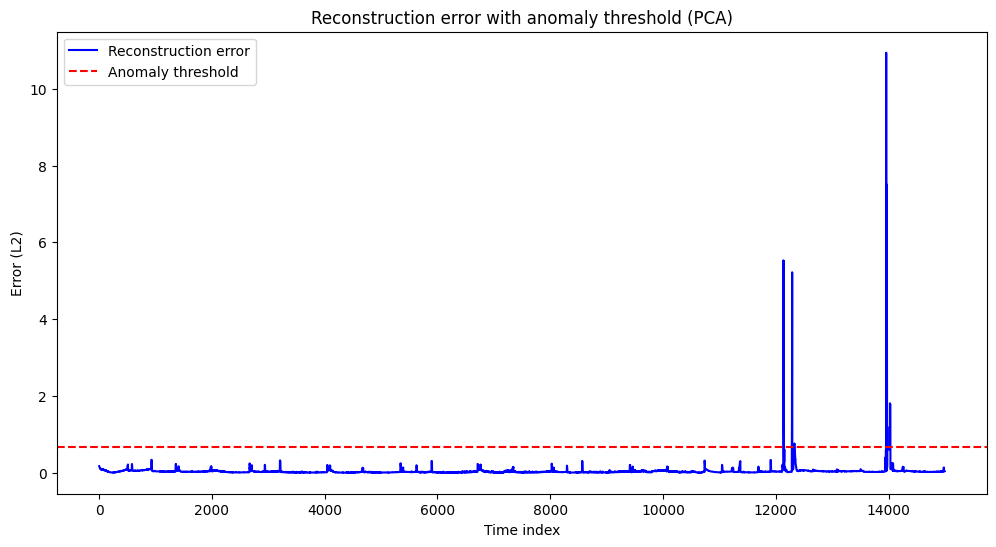

In [36]:
plot_reconstruction_error(reconstruction_error, threshold_pca)

In [37]:
len(indexes)

54

There are 54 anomalies among the 3 observed peaks on the reconstructed error.

### Isolation Forest

In [38]:
anomaly_scores_iso, anomalies_iforest = metrics_iso_forest(scaled_data)

### Local Outlier Factor

In [39]:
anomaly_scores_lof, anomalies_lof = metrics_lof(scaled_data)

### Combining Anomalies

Here we are combining the results of all three methods.

In [40]:
combined_anomalies = anomalies_pca | anomalies_iforest | anomalies_lof

In [41]:
p1_6['Anomaly'] = combined_anomalies
p1_6['Reconstruction_Error'] = reconstruction_error
p1_6['Isolation_Score'] = anomaly_scores_iso
p1_6['Lof_Score'] = anomaly_scores_lof

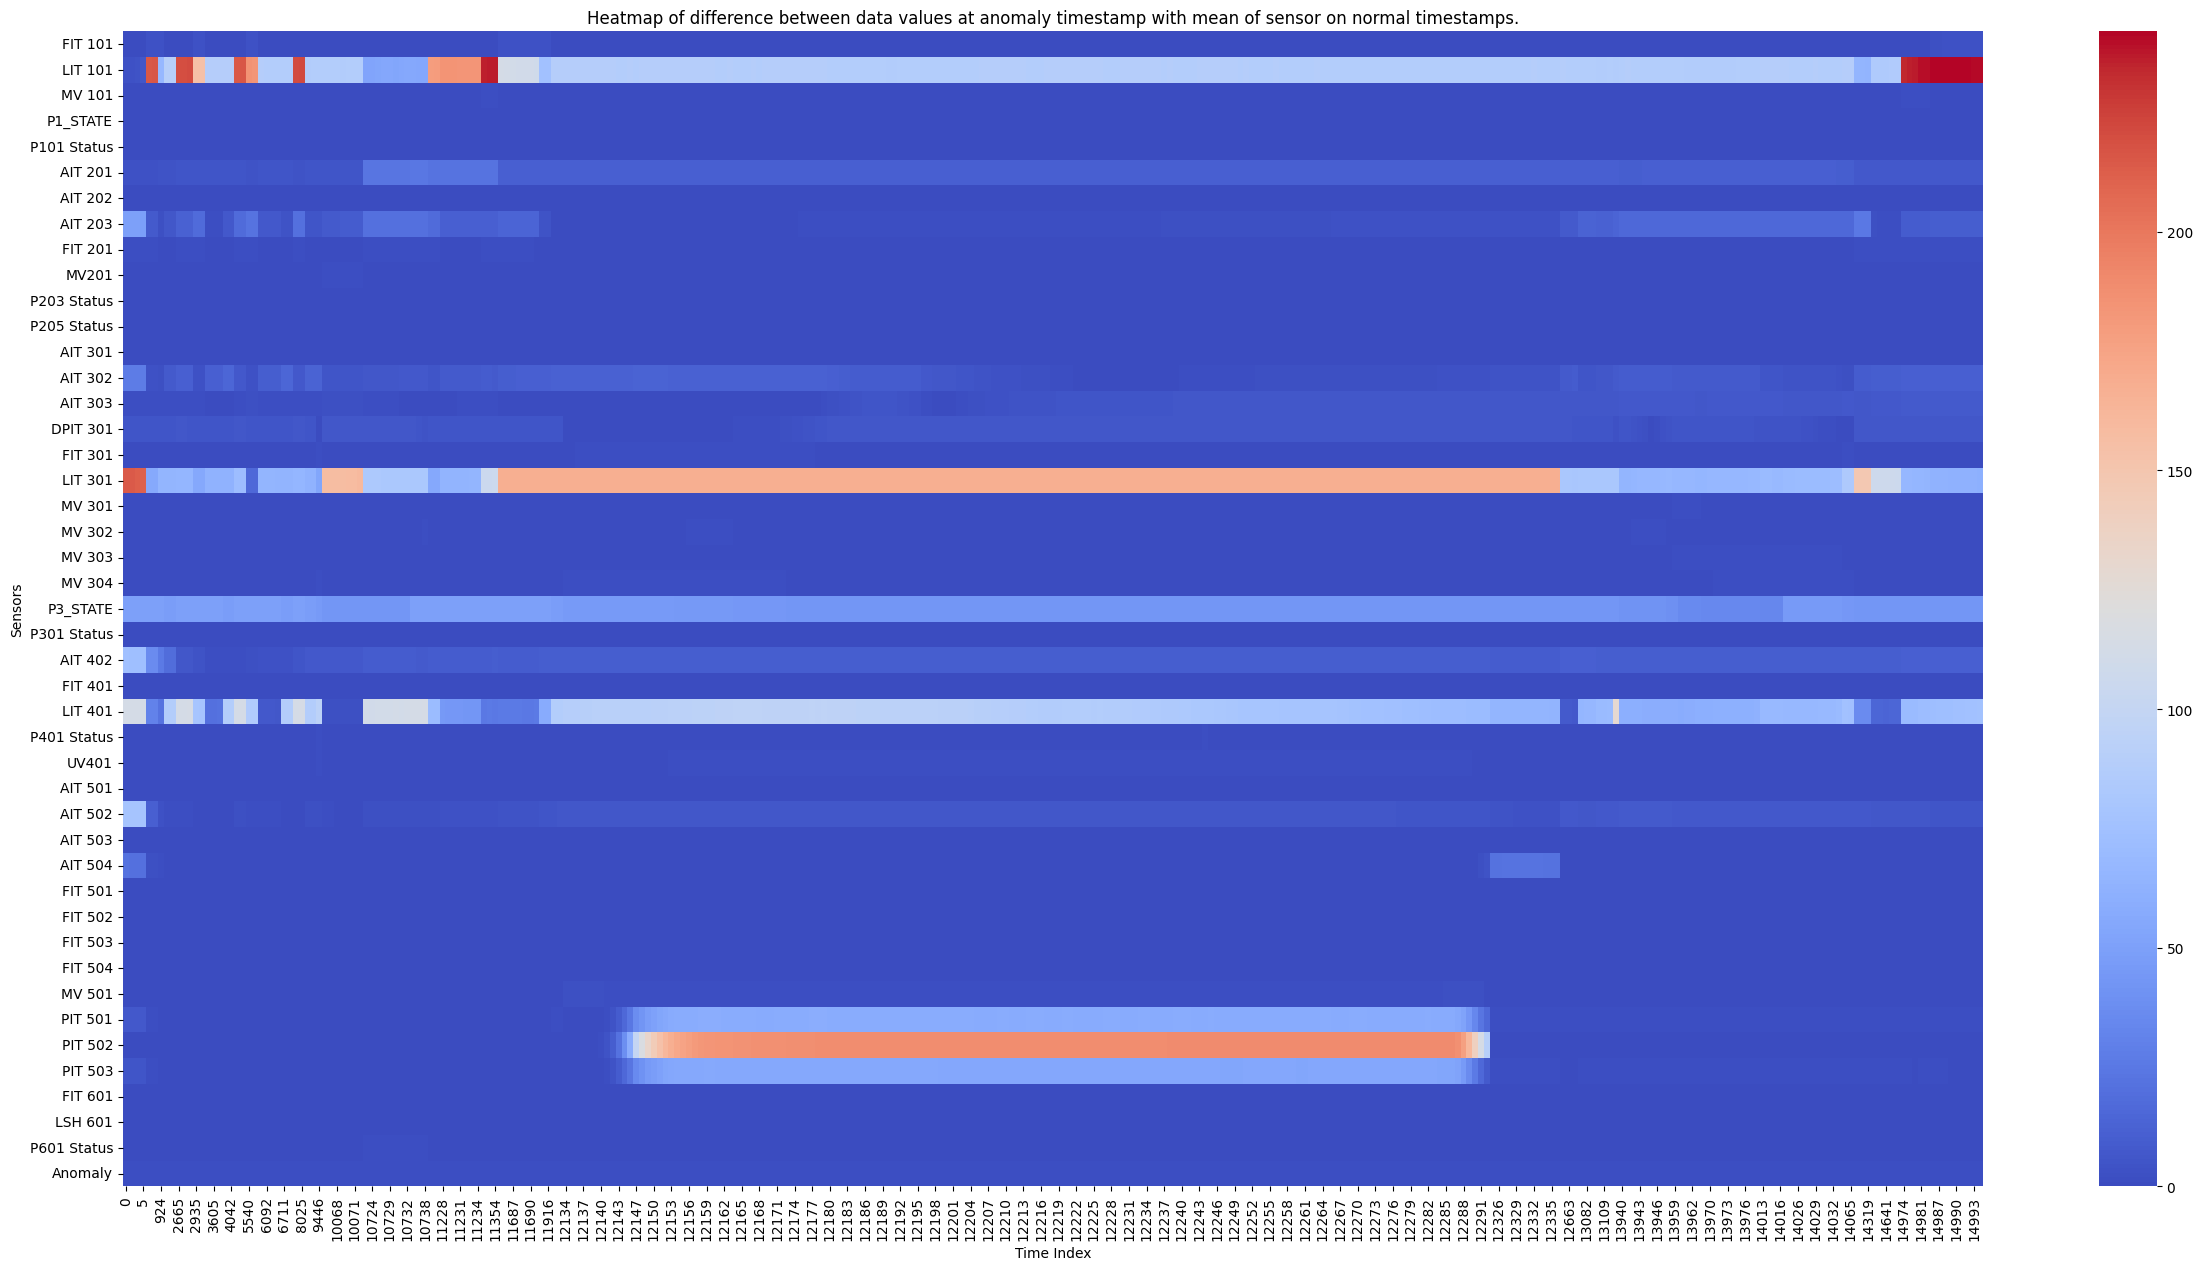

In [42]:
plot_heatmap(p1_6)

The heatmap provides information about which columns possess the biggest impact on anomaly detection.

We compute the absolute value of the difference between the value of the sensor during an attack and the mean value of the sensor under normal operation.

**Temperature at time t:**\
<br>$| x\_anomaly(t) - x\_mean |$

Here we can see that at a global scale, the sensors which are more likely to have been attacked are the following ones:
**LIT 101, LIT 301, P3_STATE, LIT 401, PIT 502, AIT 503.**

In [43]:
print(f"Total anomalies detected by PCA: {np.sum(anomalies_pca)}")
print(f"Total anomalies detected by Isolation Forest: {np.sum(anomalies_iforest)}")
print(f"Total anomalies detected by Local Outlier Factor: {np.sum(anomalies_lof)}\n\n")

check_common_anomalies_3methods(anomalies_pca, anomalies_iforest, anomalies_lof)

Total anomalies detected by PCA: 54
Total anomalies detected by Isolation Forest: 148
Total anomalies detected by Local Outlier Factor: 150


Total common anomalies detected by all methods: 6
Total common anomalies detected by PCA and Isolation Forest: 6
Total common anomalies detected by PCA and Local Outlier Factor: 28
Total common anomalies detected by Isolation Forest and Local Outlier Factor: 7


Let's compare our unsupervised predictions with true labels.

In [44]:
true_labels = prepare_dfs([labels])

print("Classification report:")
print(classification_report(true_labels, p1_6['Anomaly']))

Classification report:
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     12443
           1       0.62      0.08      0.14      2553

    accuracy                           0.83     14996
   macro avg       0.73      0.53      0.52     14996
weighted avg       0.80      0.83      0.78     14996



In terms of pure anomaly detection, the results are pretty low, but we will see after that this is enough to detect attacks.

In [45]:
cm1 = confusion_matrix(true_labels, anomalies_pca)
cm2 = confusion_matrix(true_labels, anomalies_iforest)
cm3 = confusion_matrix(true_labels, anomalies_lof)
cm4 = confusion_matrix(true_labels, p1_6['Anomaly'])

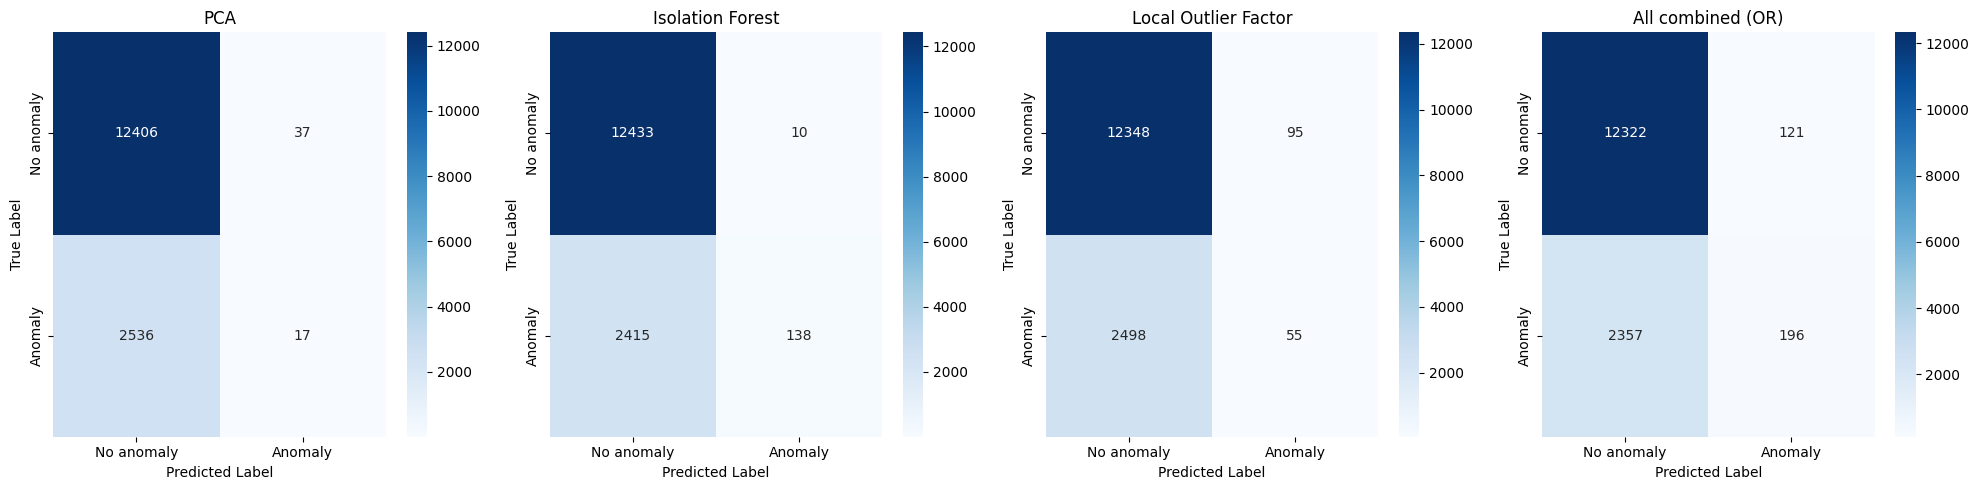

In [46]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Plot each confusion matrix
for ax, cm, title in zip(
    axes,
    [cm1, cm2, cm3, cm4],
    ['PCA', 'Isolation Forest', 'Local Outlier Factor', 'All combined (OR)']
):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No anomaly', 'Anomaly'], yticklabels=['No anomaly', 'Anomaly'], ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

# Adjust layout for better appearance
plt.tight_layout()
plt.show()

As we can see, the isolation forest > local outlier factor > pca, in term of anomaly detection.

In [53]:
attacks_dict = {(i, attack_summary.iloc[i]["Attack_Type"]): [] for i in range(len(attack_summary))}
for i, line in enumerate(attack_summary.iterrows()):
  key = list(attacks_dict.keys())[i]
  for j in range(len(anomalies_pca)):
    if anomalies_pca[j] and j >= line[1]["Start_Time_Index"] and j <= line[1]["End_Time_Index"]:
      attacks_dict[key].append(("pca", j))

  for j in range(len(anomalies_iforest)):
    if anomalies_iforest[j] and j >= line[1]["Start_Time_Index"] and j <= line[1]["End_Time_Index"]:
      attacks_dict[key].append(("iforest", j))

  for j in range(len(anomalies_lof)):
    if anomalies_lof[j] and j >= line[1]["Start_Time_Index"] and j <= line[1]["End_Time_Index"]:
      attacks_dict[key].append(("lof", j))

for k, v in attacks_dict.items():
  print(f'On attack {k[0]} of type {k[1]}, which timestamps range from {attack_summary.iloc[k[0]]["Start_Time_Index"]} to {attack_summary.iloc[k[0]]["End_Time_Index"]}, we found these anomilies : {v}')


On attack 0 of type Spoofing, which timestamps range from 9416 to 9521, we found these anomilies : [('lof', 9446)]
On attack 1 of type Spoofing, which timestamps range from 9803 to 10063, we found these anomilies : []
On attack 2 of type Switch_ON, which timestamps range from 10509 to 10738, we found these anomilies : [('lof', 10723), ('lof', 10724), ('lof', 10726), ('lof', 10727), ('lof', 10729), ('lof', 10730), ('lof', 10731), ('lof', 10732), ('lof', 10736), ('lof', 10737), ('lof', 10738)]
On attack 3 of type Switch_ON, which timestamps range from 11235 to 11684, we found these anomilies : [('lof', 11352), ('lof', 11353), ('lof', 11354)]
On attack 4 of type Switch_close, which timestamps range from 12141 to 12284, we found these anomilies : [('pca', 12141), ('pca', 12142), ('pca', 12143), ('pca', 12144), ('iforest', 12147), ('iforest', 12148), ('iforest', 12149), ('iforest', 12150), ('iforest', 12151), ('iforest', 12152), ('iforest', 12153), ('iforest', 12154), ('iforest', 12155), ('

The accuracy is mid, the anomaly aren't all detected, but it seems to be enough to detect an occuring attack, as we can see **we detect 5 out of 6 of them.**

In [54]:
metrics_pca_dict = evaluate_metrics(true_labels, anomalies_pca)
metrics_iso_forest_dict = evaluate_metrics(true_labels, anomalies_iforest)
metrics_lof_dict = evaluate_metrics(true_labels, anomalies_lof)

results = pd.DataFrame([metrics_pca_dict, metrics_iso_forest_dict, metrics_lof_dict],
                       index=["PCA", "Isolation Forest", "Local Outlier Factor"])

print(results)

                      Precision    Recall  F1-Score       MCC  \
PCA                    0.314815  0.006659  0.013042  0.023124   
Isolation Forest       0.932432  0.054054  0.102184  0.202463   
Local Outlier Factor   0.366667  0.021543  0.040696  0.052531   

                      Balanced Accuracy   AUC-PRC  
PCA                            0.501843  0.501843  
Isolation Forest               0.526625  0.526625  
Local Outlier Factor           0.506954  0.506954  


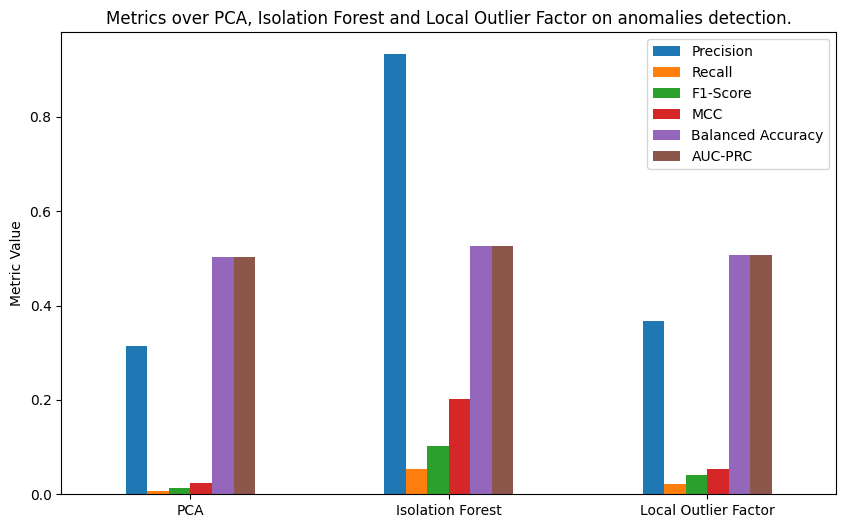

In [55]:
results.plot(kind='bar', figsize=(10, 6), title='Metrics over PCA, Isolation Forest and Local Outlier Factor on anomalies detection.')
plt.ylabel('Metric Value')
plt.xticks(rotation=0)
plt.legend(loc='upper right')
plt.show()

## Single Stage Multi Point (SSMP)
Targets multiple sensors at a single point in time.

### SSMP - P1

Scaled data shape: (14996, 5)
PCA components: (14996, 4)
Number of anomalies: 105

Confusion matrix :

[[12204   239]
 [ 2523    30]]


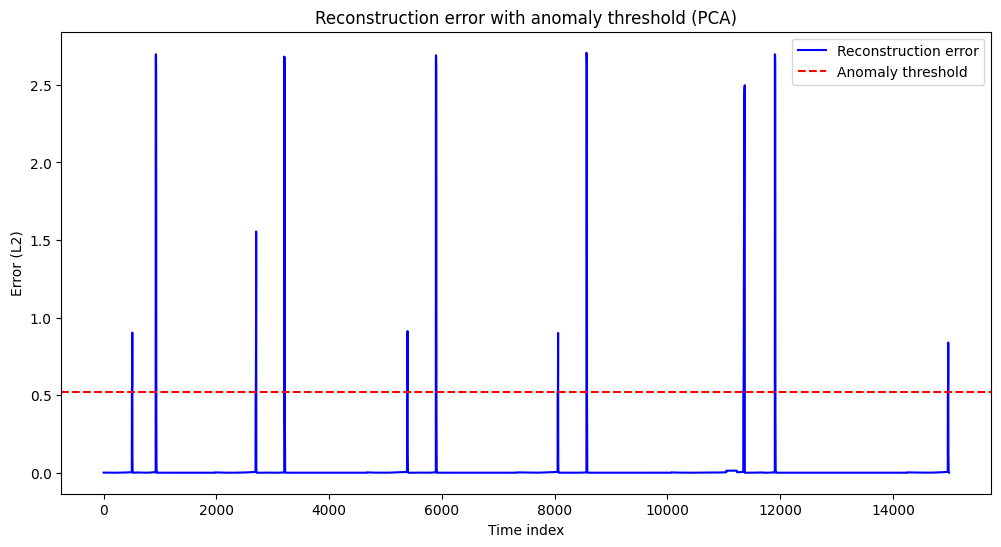

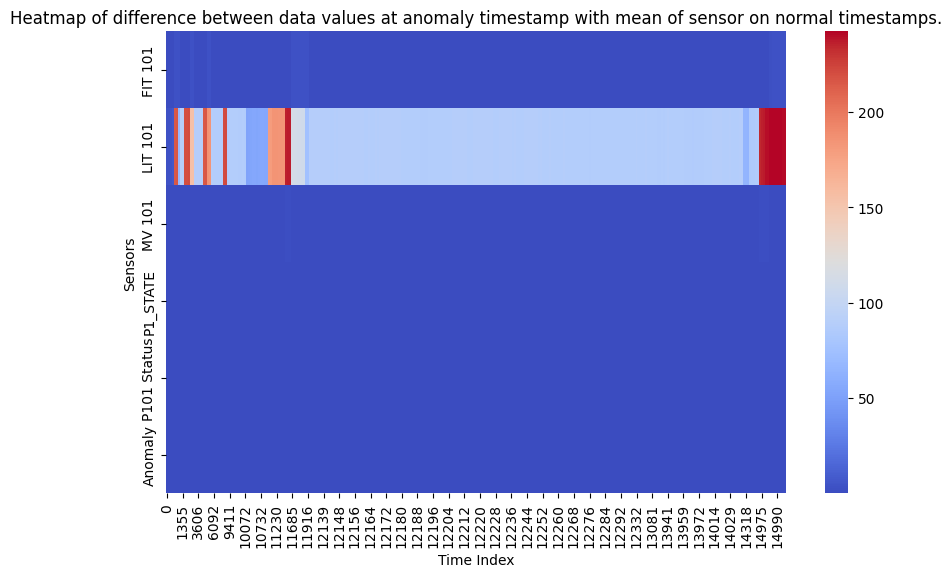

Total anomalies detected by PCA: 105
Total anomalies detected by Isolation Forest: 150
Total anomalies detected by Local Outlier Factor: 150


Total common anomalies detected by all methods: 32
Total common anomalies detected by PCA and Isolation Forest: 93
Total common anomalies detected by PCA and Local Outlier Factor: 33
Total common anomalies detected by Isolation Forest and Local Outlier Factor: 42


In [56]:
p1 = prepare_dfs([p1_])
scaled_data = scale_data(p1)

pca_components, pca = pca_(scaled_data)
reconstruction_error, threshold_pca, anomalies_pca, indexes = metrics_pca(pca, pca_components, scaled_data)

anomaly_scores_iso, anomalies_iforest = metrics_iso_forest(scaled_data)

anomaly_scores_lof, anomalies_lof = metrics_lof(scaled_data)

combined_anomalies_p1_or = anomalies_pca | anomalies_iforest | anomalies_lof

print("\nConfusion matrix :\n")
print(confusion_matrix(labels, combined_anomalies_p1_or))

p1['Anomaly'] = combined_anomalies
p1['Reconstruction_Error'] = reconstruction_error
p1['Isolation_Score'] = anomaly_scores_iso
p1['Lof_Score'] = anomaly_scores_lof

plot_reconstruction_error(reconstruction_error, threshold_pca)
plot_heatmap(p1, (10, 6))

print(f"Total anomalies detected by PCA: {np.sum(anomalies_pca)}")
print(f"Total anomalies detected by Isolation Forest: {np.sum(anomalies_iforest)}")
print(f"Total anomalies detected by Local Outlier Factor: {np.sum(anomalies_lof)}\n\n")

check_common_anomalies_3methods(anomalies_pca, anomalies_iforest, anomalies_lof)

### SSMP - P2

Scaled data shape: (14996, 7)
PCA components: (14996, 3)
Number of anomalies: 191

Confusion matrix :

[[12197   246]
 [ 2482    71]]


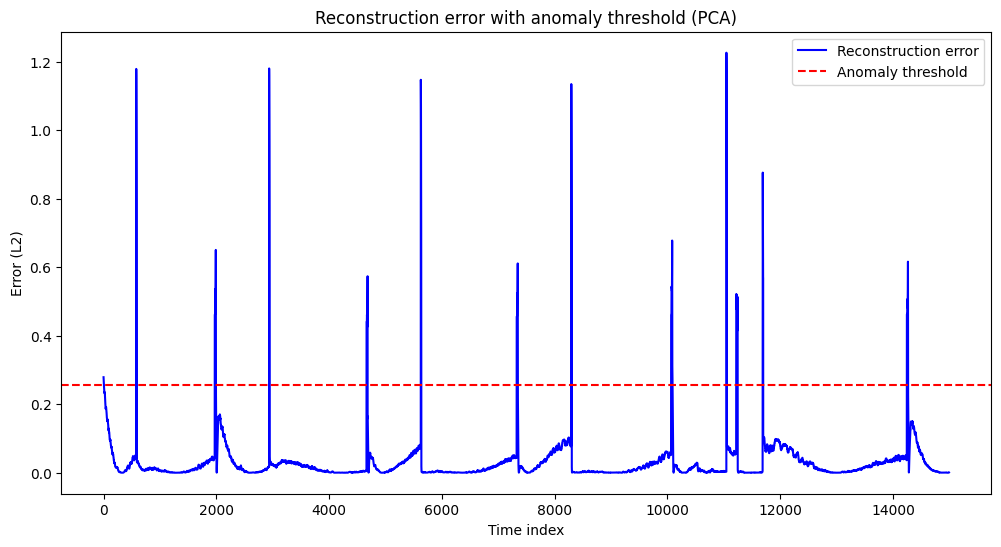

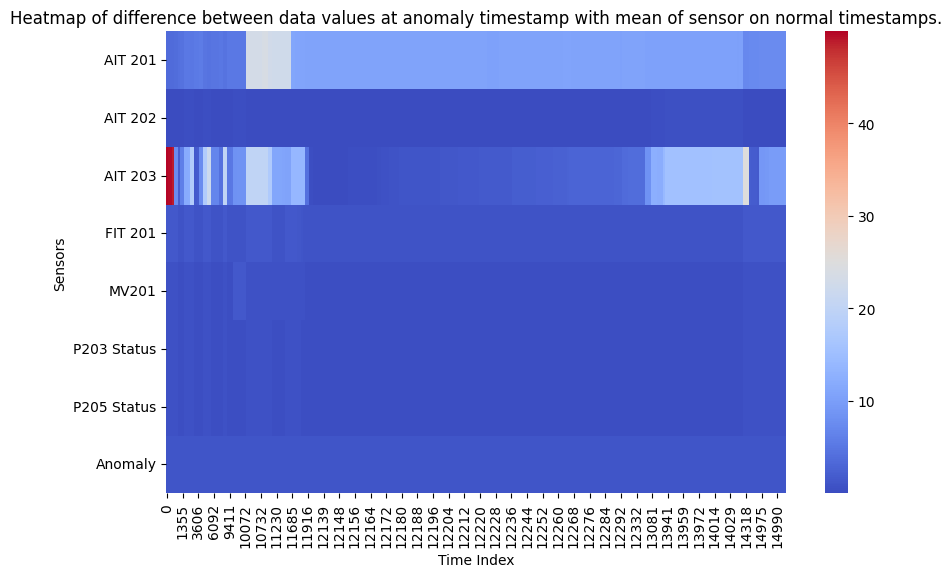

Total anomalies detected by PCA: 191
Total anomalies detected by Isolation Forest: 150
Total anomalies detected by Local Outlier Factor: 150


Total common anomalies detected by all methods: 29
Total common anomalies detected by PCA and Isolation Forest: 111
Total common anomalies detected by PCA and Local Outlier Factor: 49
Total common anomalies detected by Isolation Forest and Local Outlier Factor: 43


In [57]:
p2 = prepare_dfs([p2_])
scaled_data = scale_data(p2)

pca_components, pca = pca_(scaled_data)
reconstruction_error, threshold_pca, anomalies_pca, indexes = metrics_pca(pca, pca_components, scaled_data)

anomaly_scores_iso, anomalies_iforest = metrics_iso_forest(scaled_data)

anomaly_scores_lof, anomalies_lof = metrics_lof(scaled_data)

combined_anomalies_p2_or = anomalies_pca | anomalies_iforest | anomalies_lof

print("\nConfusion matrix :\n")
print(confusion_matrix(labels, combined_anomalies_p2_or))

p2['Anomaly'] = combined_anomalies
p2['Reconstruction_Error'] = reconstruction_error
p2['Isolation_Score'] = anomaly_scores_iso
p2['Lof_Score'] = anomaly_scores_lof

plot_reconstruction_error(reconstruction_error, threshold_pca)
plot_heatmap(p2, (10, 6))

print(f"Total anomalies detected by PCA: {np.sum(anomalies_pca)}")
print(f"Total anomalies detected by Isolation Forest: {np.sum(anomalies_iforest)}")
print(f"Total anomalies detected by Local Outlier Factor: {np.sum(anomalies_lof)}\n\n")

check_common_anomalies_3methods(anomalies_pca, anomalies_iforest, anomalies_lof)

### SSMP - P3

Scaled data shape: (14996, 12)
PCA components: (14996, 7)
Number of anomalies: 213

Confusion matrix :

[[12200   243]
 [ 2401   152]]


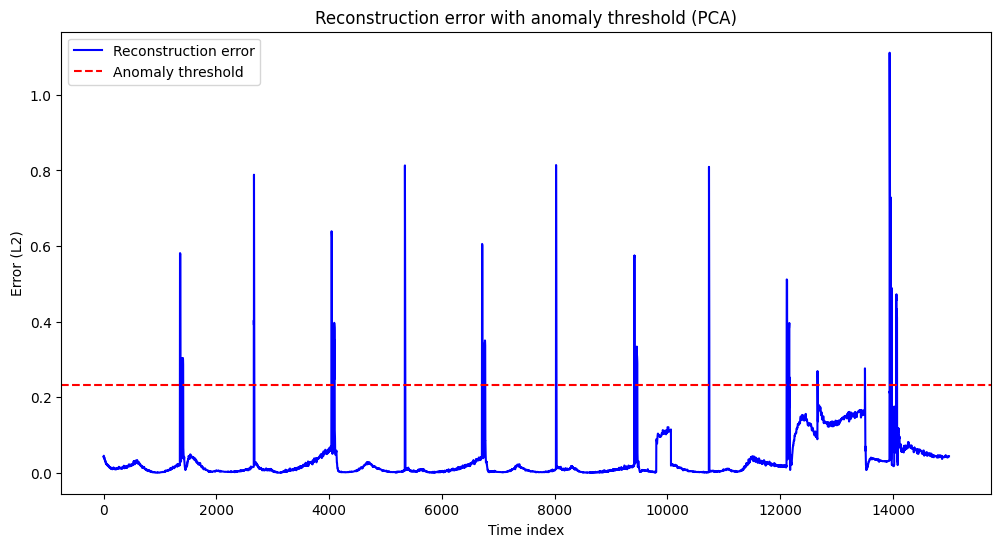

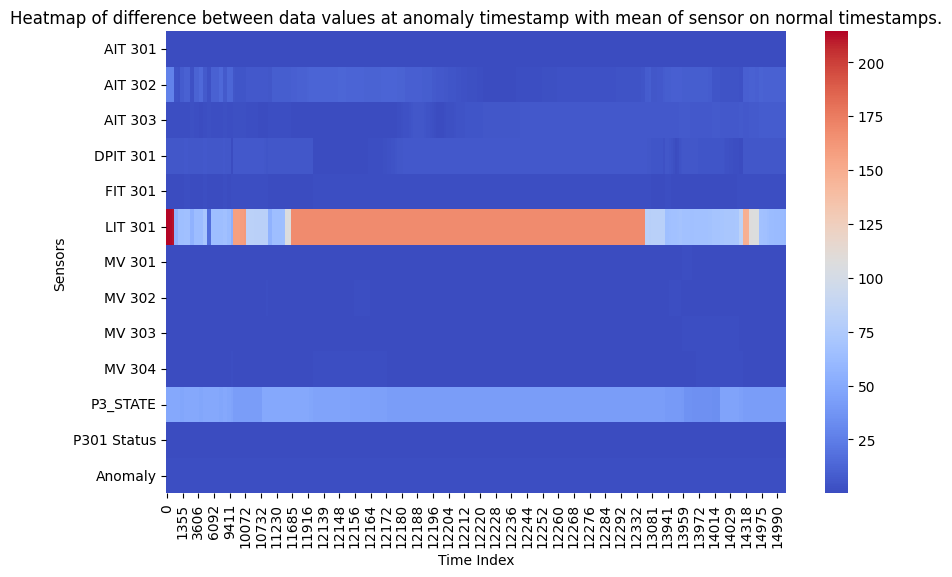

Total anomalies detected by PCA: 213
Total anomalies detected by Isolation Forest: 150
Total anomalies detected by Local Outlier Factor: 150


Total common anomalies detected by all methods: 22
Total common anomalies detected by PCA and Isolation Forest: 52
Total common anomalies detected by PCA and Local Outlier Factor: 56
Total common anomalies detected by Isolation Forest and Local Outlier Factor: 32


In [58]:
p3 = prepare_dfs([p3_])
scaled_data = scale_data(p3)

pca_components, pca = pca_(scaled_data)
reconstruction_error, threshold_pca, anomalies_pca, indexes = metrics_pca(pca, pca_components, scaled_data)

anomaly_scores_iso, anomalies_iforest = metrics_iso_forest(scaled_data)

anomaly_scores_lof, anomalies_lof = metrics_lof(scaled_data)

combined_anomalies_p3_or = anomalies_pca | anomalies_iforest | anomalies_lof

print("\nConfusion matrix :\n")
print(confusion_matrix(labels, combined_anomalies_p3_or))

p3['Anomaly'] = combined_anomalies
p3['Reconstruction_Error'] = reconstruction_error
p3['Isolation_Score'] = anomaly_scores_iso
p3['Lof_Score'] = anomaly_scores_lof

plot_reconstruction_error(reconstruction_error, threshold_pca)
plot_heatmap(p3, (10, 6))

print(f"Total anomalies detected by PCA: {np.sum(anomalies_pca)}")
print(f"Total anomalies detected by Isolation Forest: {np.sum(anomalies_iforest)}")
print(f"Total anomalies detected by Local Outlier Factor: {np.sum(anomalies_lof)}\n\n")

check_common_anomalies_3methods(anomalies_pca, anomalies_iforest, anomalies_lof)

### SSMP - P4

Scaled data shape: (14996, 5)
PCA components: (14996, 4)
Number of anomalies: 12

Confusion matrix :

[[12329   114]
 [ 2374   179]]


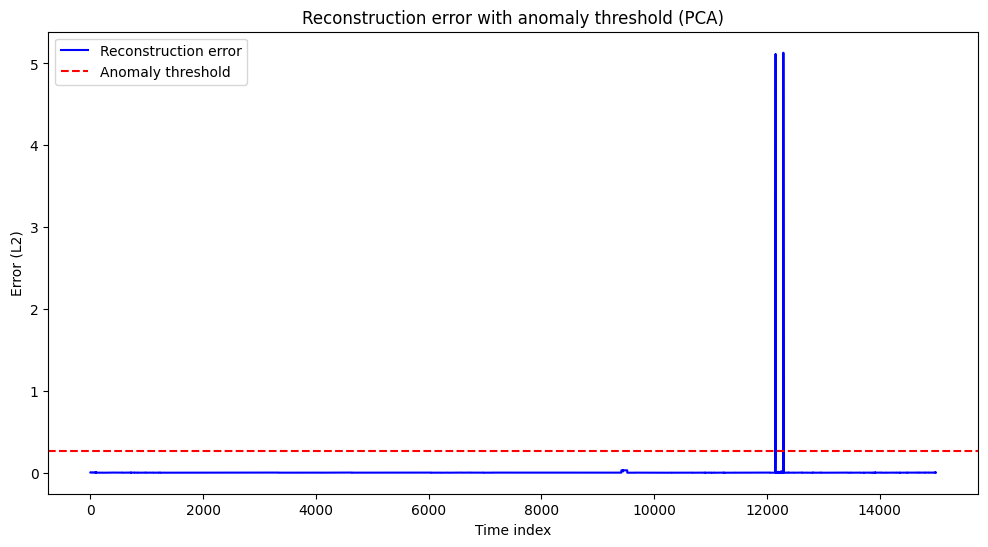

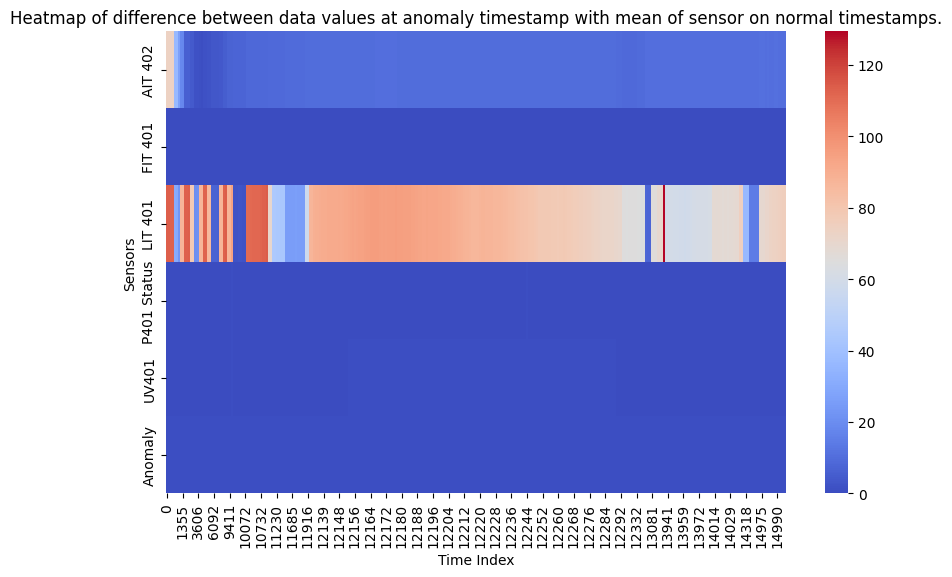

Total anomalies detected by PCA: 12
Total anomalies detected by Isolation Forest: 147
Total anomalies detected by Local Outlier Factor: 150


Total common anomalies detected by all methods: 0
Total common anomalies detected by PCA and Isolation Forest: 0
Total common anomalies detected by PCA and Local Outlier Factor: 12
Total common anomalies detected by Isolation Forest and Local Outlier Factor: 4


In [59]:
p4 = prepare_dfs([p4_])
scaled_data = scale_data(p4)

pca_components, pca = pca_(scaled_data)
reconstruction_error, threshold_pca, anomalies_pca, indexes = metrics_pca(pca, pca_components, scaled_data)

anomaly_scores_iso, anomalies_iforest = metrics_iso_forest(scaled_data)

anomaly_scores_lof, anomalies_lof = metrics_lof(scaled_data)

combined_anomalies_p4_or = anomalies_pca | anomalies_iforest | anomalies_lof

print("\nConfusion matrix :\n")
print(confusion_matrix(labels, combined_anomalies_p4_or))

p4['Anomaly'] = combined_anomalies
p4['Reconstruction_Error'] = reconstruction_error
p4['Isolation_Score'] = anomaly_scores_iso
p4['Lof_Score'] = anomaly_scores_lof

plot_reconstruction_error(reconstruction_error, threshold_pca)
plot_heatmap(p4, (10, 6))

print(f"Total anomalies detected by PCA: {np.sum(anomalies_pca)}")
print(f"Total anomalies detected by Isolation Forest: {np.sum(anomalies_iforest)}")
print(f"Total anomalies detected by Local Outlier Factor: {np.sum(anomalies_lof)}\n\n")

check_common_anomalies_3methods(anomalies_pca, anomalies_iforest, anomalies_lof)

### SSMP - P5

Scaled data shape: (14996, 12)
PCA components: (14996, 5)
Number of anomalies: 43

Confusion matrix :

[[12296   147]
 [ 2396   157]]


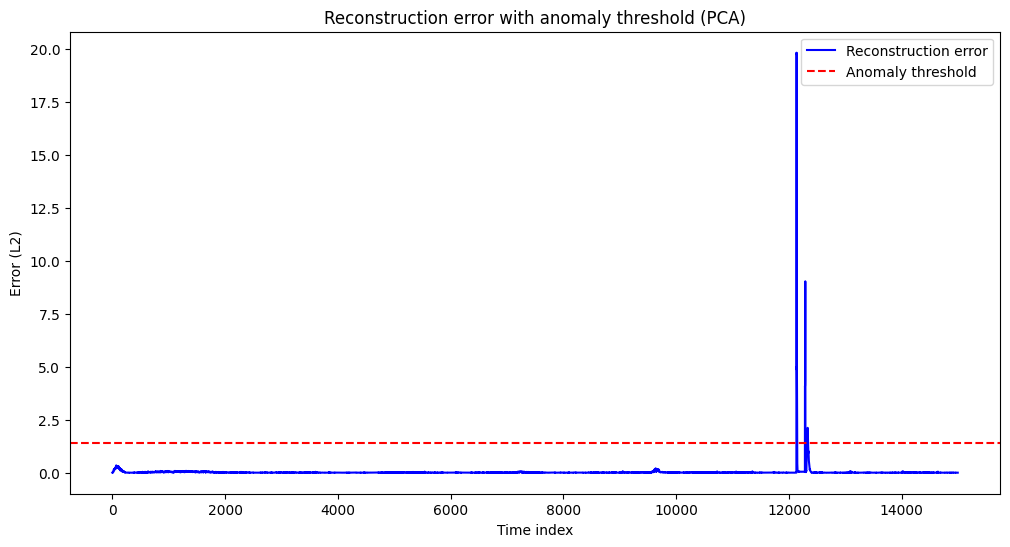

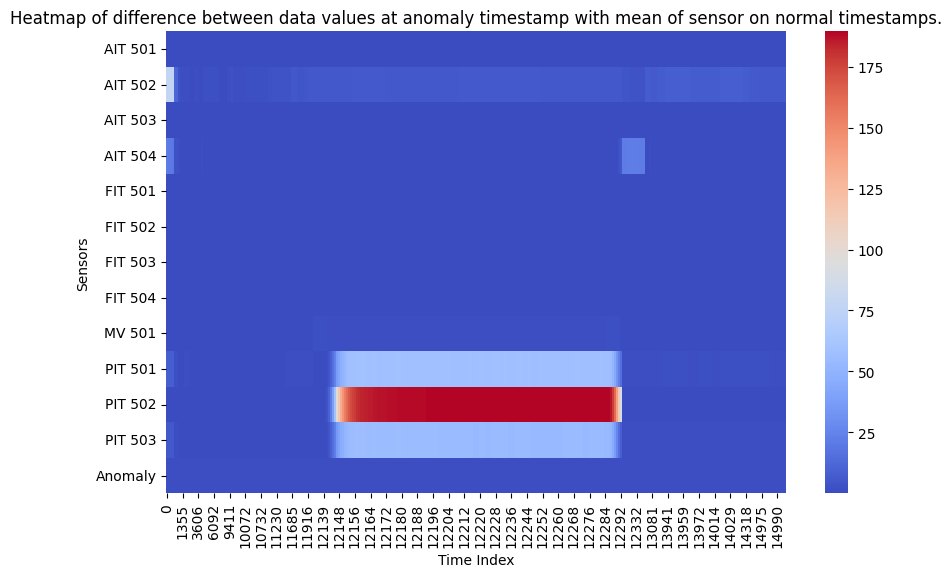

Total anomalies detected by PCA: 43
Total anomalies detected by Isolation Forest: 149
Total anomalies detected by Local Outlier Factor: 150


Total common anomalies detected by all methods: 5
Total common anomalies detected by PCA and Isolation Forest: 5
Total common anomalies detected by PCA and Local Outlier Factor: 20
Total common anomalies detected by Isolation Forest and Local Outlier Factor: 18


In [60]:
p5 = prepare_dfs([p5_])
scaled_data = scale_data(p5)

pca_components, pca = pca_(scaled_data)
reconstruction_error, threshold_pca, anomalies_pca, indexes = metrics_pca(pca, pca_components, scaled_data)

anomaly_scores_iso, anomalies_iforest = metrics_iso_forest(scaled_data)

anomaly_scores_lof, anomalies_lof = metrics_lof(scaled_data)

combined_anomalies_p5_or = anomalies_pca | anomalies_iforest | anomalies_lof

print("\nConfusion matrix :\n")
print(confusion_matrix(labels, combined_anomalies_p5_or))

p5['Anomaly'] = combined_anomalies
p5['Reconstruction_Error'] = reconstruction_error
p5['Isolation_Score'] = anomaly_scores_iso
p5['Lof_Score'] = anomaly_scores_lof

plot_reconstruction_error(reconstruction_error, threshold_pca)
plot_heatmap(p5, (10, 6))

print(f"Total anomalies detected by PCA: {np.sum(anomalies_pca)}")
print(f"Total anomalies detected by Isolation Forest: {np.sum(anomalies_iforest)}")
print(f"Total anomalies detected by Local Outlier Factor: {np.sum(anomalies_lof)}\n\n")

check_common_anomalies_3methods(anomalies_pca, anomalies_iforest, anomalies_lof)

### SSMP - P6

Scaled data shape: (14996, 3)
PCA components: (14996, 3)
Number of anomalies: 1

Confusion matrix :

[[12385    58]
 [ 2533    20]]


/home/alex/cyberml_projet/.venv/lib/python3.10/site-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


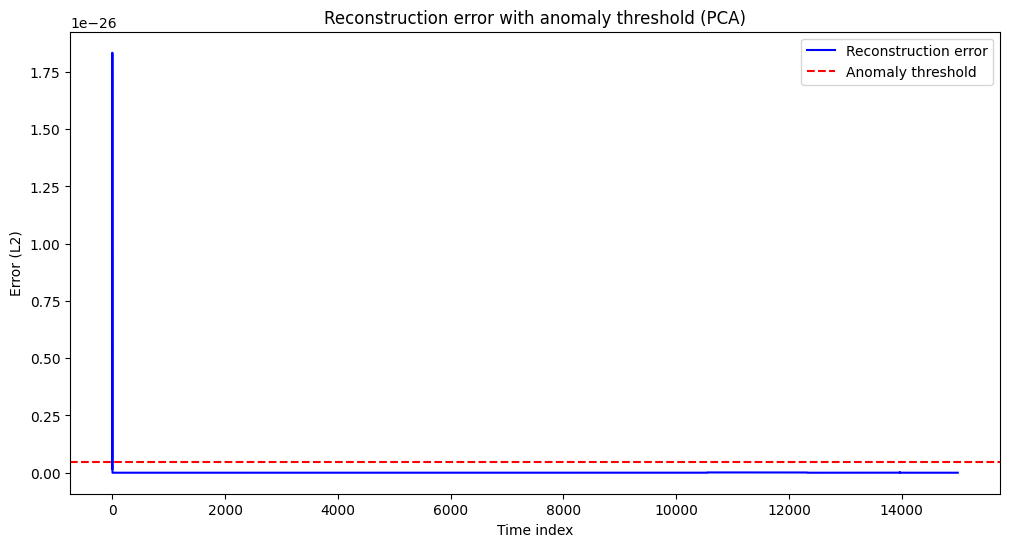

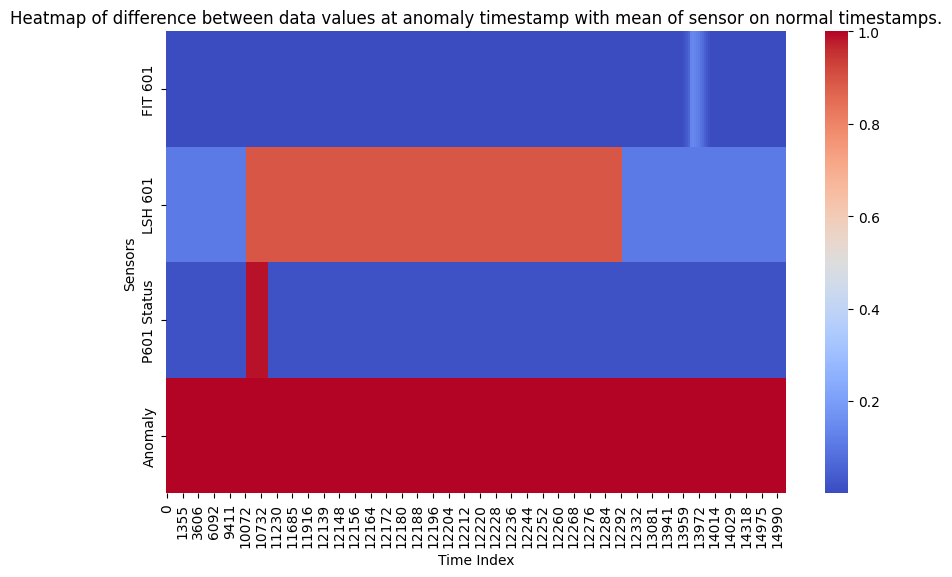

Total anomalies detected by PCA: 1
Total anomalies detected by Isolation Forest: 43
Total anomalies detected by Local Outlier Factor: 45


Total common anomalies detected by all methods: 0
Total common anomalies detected by PCA and Isolation Forest: 0
Total common anomalies detected by PCA and Local Outlier Factor: 0
Total common anomalies detected by Isolation Forest and Local Outlier Factor: 11


In [61]:
p6 = prepare_dfs([p6_])
scaled_data = scale_data(p6)

pca_components, pca = pca_(scaled_data)
reconstruction_error, threshold_pca, anomalies_pca, indexes = metrics_pca(pca, pca_components, scaled_data)

anomaly_scores_iso, anomalies_iforest = metrics_iso_forest(scaled_data)

anomaly_scores_lof, anomalies_lof = metrics_lof(scaled_data)

combined_anomalies_p6_or = anomalies_pca | anomalies_iforest | anomalies_lof

print("\nConfusion matrix :\n")
print(confusion_matrix(labels, combined_anomalies_p6_or))

p6['Anomaly'] = combined_anomalies
p6['Reconstruction_Error'] = reconstruction_error
p6['Isolation_Score'] = anomaly_scores_iso
p6['Lof_Score'] = anomaly_scores_lof

plot_reconstruction_error(reconstruction_error, threshold_pca)
plot_heatmap(p6, (10, 6))

print(f"Total anomalies detected by PCA: {np.sum(anomalies_pca)}")
print(f"Total anomalies detected by Isolation Forest: {np.sum(anomalies_iforest)}")
print(f"Total anomalies detected by Local Outlier Factor: {np.sum(anomalies_lof)}\n\n")

check_common_anomalies_3methods(anomalies_pca, anomalies_iforest, anomalies_lof)

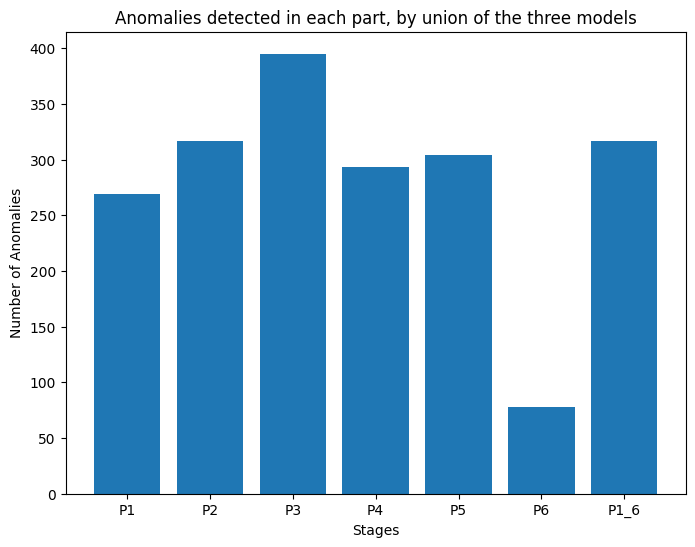

In [62]:
anomalies_count = {
    "P1": np.sum(combined_anomalies_p1_or),
    "P2": np.sum(combined_anomalies_p2_or),
    "P3": np.sum(combined_anomalies_p3_or),
    "P4": np.sum(combined_anomalies_p4_or),
    "P5": np.sum(combined_anomalies_p5_or),
    "P6": np.sum(combined_anomalies_p6_or),
    "P1_6": np.sum(combined_anomalies)
}

plt.figure(figsize=(8, 6))
plt.bar(anomalies_count.keys(), anomalies_count.values())
plt.title('Anomalies detected in each part, by union of the three models')
plt.ylabel('Number of Anomalies')
plt.xlabel('Stages')
plt.show()


In [63]:
combined_anomalies = (
    combined_anomalies_p1_or | combined_anomalies_p2_or | combined_anomalies_p3_or | combined_anomalies_p4_or | combined_anomalies_p5_or | combined_anomalies_p6_or
)
total_anomalies = combined_anomalies

In [65]:
print("Total counted anomalies combined ", total_anomalies.sum())

Total counted anomalies combined  1415


In [66]:
print("Classification Report:")
print(classification_report(true_labels, total_anomalies))

cm_combined = confusion_matrix(true_labels, total_anomalies)

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.92      0.88     12443
           1       0.30      0.17      0.21      2553

    accuracy                           0.79     14996
   macro avg       0.57      0.54      0.55     14996
weighted avg       0.75      0.79      0.77     14996



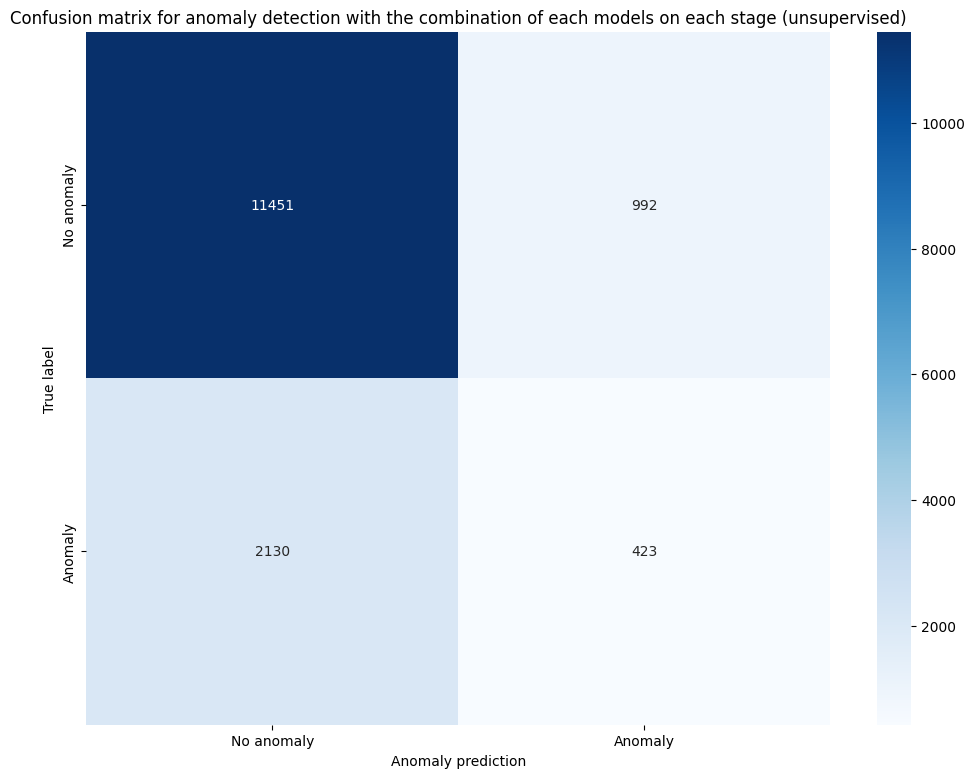

In [67]:
plt.figure(figsize=(12, 9))
sns.heatmap(cm_combined, annot=True, fmt='d', cmap='Blues', xticklabels=['No anomaly', 'Anomaly'], yticklabels=['No anomaly', 'Anomaly'])
plt.title('Confusion matrix for anomaly detection with the combination of each models on each stage (unsupervised)')
plt.xlabel('Anomaly prediction')
plt.ylabel('True label')
plt.show()

### Attack types
The provided paper tells us this:

0. Total number of attacks: 36.
1. ***SSSP***: 26
2. ***SSMP***: 4
3. ***MSSP***: 2
4. ***MSMP***: 4

# Deep learning approaches (Supervised)

Let's prepare the data to train a supervised model to predict anomalies.

- Features (X): all sensor data from P1-P6 stages
- Target (y): the binary labels for anomalies (0 for normal, 1 for anomaly)
- Train-test split: 70-30 ratio

In [68]:
df_for_mlp = prepare_dfs([labels, p1_, p2_, p3_, p4_, p5_, p6_])

In [69]:
df_for_mlp.head()

,Label,FIT 101,LIT 101,MV 101,P1_STATE,P101 Status,AIT 201,AIT 202,AIT 203,FIT 201,MV201,P203 Status,P205 Status,AIT 301,AIT 302,AIT 303,DPIT 301,FIT 301,LIT 301,MV 301,MV 302,MV 303,MV 304,P3_STATE,P301 Status,AIT 402,FIT 401,LIT 401,P401 Status,UV401,AIT 501,AIT 502,AIT 503,AIT 504,FIT 501,FIT 502,FIT 503,FIT 504,MV 501,PIT 501,PIT 502,PIT 503,FIT 601,LSH 601,P601 Status
0,0,0.0,729.8658,1,3,2,142.527557,9.293002,198.077423,2.335437,2,2,2,8.522921,256.431274,143.158966,1.190857,0.000512,730.702100,1,1,1,1,99,1,87.951805,0.781740,1000.62805,2,2,7.489618,147.398100,1016.27789,46.065113,0.781594,0.310362,0.623628,0.213432,2,167.601257,2.963509,119.921173,0.00032,1,1
1,0,0.0,729.4340,1,3,2,142.527557,9.293002,198.385025,2.335437,2,2,2,8.522921,256.431274,143.158966,1.190857,0.000512,730.902344,1,1,1,1,99,1,87.823630,0.782380,1000.55115,2,2,7.489618,147.398100,1016.27789,45.757500,0.782235,0.315102,0.623628,0.212984,2,167.601257,2.963509,119.921173,0.00032,1,1
2,0,0.0,729.1200,1,3,2,142.527557,9.293002,198.436300,2.335437,2,2,2,8.522921,256.431274,143.158966,1.190857,0.000512,732.344300,1,1,1,1,99,1,87.798004,0.783021,1000.28200,2,2,7.489618,147.398100,1016.27789,45.603690,0.782235,0.317023,0.623628,0.212984,2,167.601257,2.963509,119.921173,0.00032,1,1
3,0,0.0,728.6882,1,3,2,142.527557,9.289157,198.667000,2.335437,2,2,2,8.522921,256.431274,143.158966,1.190857,0.000512,732.704800,1,1,1,1,99,1,87.695465,0.783021,1000.74341,2,2,7.489618,147.167389,1016.27789,45.603690,0.783133,0.308057,0.623628,0.212792,2,167.601257,2.963509,119.921173,0.00032,1,1
4,0,0.0,727.7069,1,3,2,142.527557,9.289157,198.897720,2.335437,2,2,2,8.522921,256.431274,143.158966,1.190857,0.000512,732.744800,1,1,1,1,99,1,87.618560,0.781228,1000.39734,2,2,7.489618,147.090485,1016.27789,45.219173,0.783773,0.303446,0.623628,0.214009,2,167.601257,2.963509,119.921173,0.00032,1,1


In [70]:
X = df_for_mlp.drop(['Label'], axis=1)
y = df_for_mlp['Label'].astype(int)

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Base binary classification model

The first deep learning approach implemented a binary classifier to detect anomalies vs normal behavior. This architecture was chosen for its simplicity and effectiveness.

In [72]:
model = Sequential([
    Dense(64, activation='relu', input_dim=X_train.shape[1]),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2)

/home/alex/cyberml_projet/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1737055500.827532  282279 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6280 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Epoch 1/30


I0000 00:00:1737055501.951781  284686 service.cc:148] XLA service 0x7cf6ac002d40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737055501.951801  284686 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2025-01-16 20:25:01.968857: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
E0000 00:00:1737055502.063258  284686 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.0.0 but source was compiled with: 9.3.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
E0000 00:00:1737055502.082741  284686 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.0.0 but s

FailedPreconditionError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/alex/cyberml_projet/.venv/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/alex/cyberml_projet/.venv/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/alex/cyberml_projet/.venv/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/alex/cyberml_projet/.venv/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/alex/cyberml_projet/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/alex/cyberml_projet/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/alex/cyberml_projet/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/alex/cyberml_projet/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/alex/cyberml_projet/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/alex/cyberml_projet/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/alex/cyberml_projet/.venv/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/alex/cyberml_projet/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/alex/cyberml_projet/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/alex/cyberml_projet/.venv/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/alex/cyberml_projet/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/alex/cyberml_projet/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/alex/cyberml_projet/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_282279/3523716442.py", line 9, in <module>

  File "/home/alex/cyberml_projet/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/alex/cyberml_projet/.venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/home/alex/cyberml_projet/.venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/home/alex/cyberml_projet/.venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

DNN library initialization failed. Look at the errors above for more details.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_multi_step_on_iterator_1399]

In [ ]:
y_pred = model.predict(X_test)
y_pred_labels = (y_pred > 0.5).astype(int)

print(classification_report(y_test, y_pred_labels))

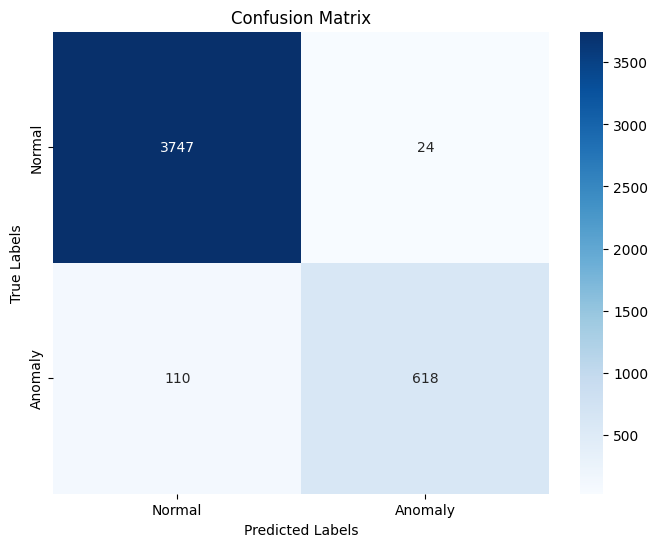

In [103]:
cm = confusion_matrix(y_test, y_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion matrix (anomaly classification)')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

Better performance than the unsupervised methods discussed earlier.

The results showed strong performance beacause we have:
- High precision and recall for normal cases (class 0)
- Good performance on anomaly detection (class 1)

Despite those good metrics, there is much more false negative than false positive which can be problematic in such cybersecurity problems. 

## Attacks types without labels

Now let's prepare the data and create a model to classify the data among five categories:
- Benign
- Spoofing
- Switch_ON
- Switch_close
- Switch_off

The training data is composed of:
- Features (X): all sensor data from P1-P6 stages
- Target (y): the class of the attack
- Train-test split: 70-30 ratio

In [73]:
df_for_mlp_types = pd.concat([attacks, prepare_dfs([p1_, p2_, p3_, p4_, p5_, p6_])], axis=1).copy()

In [74]:
df_for_mlp_types['Attack'].unique()

array(['benign', 'Spoofing', 'Switch_ON', 'Switch_close', 'Switch_off'],
      dtype=object)

In [75]:
df_for_mlp_types.head()

,Attack,FIT 101,LIT 101,MV 101,P1_STATE,P101 Status,AIT 201,AIT 202,AIT 203,FIT 201,MV201,P203 Status,P205 Status,AIT 301,AIT 302,AIT 303,DPIT 301,FIT 301,LIT 301,MV 301,MV 302,MV 303,MV 304,P3_STATE,P301 Status,AIT 402,FIT 401,LIT 401,P401 Status,UV401,AIT 501,AIT 502,AIT 503,AIT 504,FIT 501,FIT 502,FIT 503,FIT 504,MV 501,PIT 501,PIT 502,PIT 503,FIT 601,LSH 601,P601 Status
0,benign,0.0,729.8658,1,3,2,142.527557,9.293002,198.077423,2.335437,2,2,2,8.522921,256.431274,143.158966,1.190857,0.000512,730.702100,1,1,1,1,99,1,87.951805,0.781740,1000.62805,2,2,7.489618,147.398100,1016.27789,46.065113,0.781594,0.310362,0.623628,0.213432,2,167.601257,2.963509,119.921173,0.00032,1,1
1,benign,0.0,729.4340,1,3,2,142.527557,9.293002,198.385025,2.335437,2,2,2,8.522921,256.431274,143.158966,1.190857,0.000512,730.902344,1,1,1,1,99,1,87.823630,0.782380,1000.55115,2,2,7.489618,147.398100,1016.27789,45.757500,0.782235,0.315102,0.623628,0.212984,2,167.601257,2.963509,119.921173,0.00032,1,1
2,benign,0.0,729.1200,1,3,2,142.527557,9.293002,198.436300,2.335437,2,2,2,8.522921,256.431274,143.158966,1.190857,0.000512,732.344300,1,1,1,1,99,1,87.798004,0.783021,1000.28200,2,2,7.489618,147.398100,1016.27789,45.603690,0.782235,0.317023,0.623628,0.212984,2,167.601257,2.963509,119.921173,0.00032,1,1
3,benign,0.0,728.6882,1,3,2,142.527557,9.289157,198.667000,2.335437,2,2,2,8.522921,256.431274,143.158966,1.190857,0.000512,732.704800,1,1,1,1,99,1,87.695465,0.783021,1000.74341,2,2,7.489618,147.167389,1016.27789,45.603690,0.783133,0.308057,0.623628,0.212792,2,167.601257,2.963509,119.921173,0.00032,1,1
4,benign,0.0,727.7069,1,3,2,142.527557,9.289157,198.897720,2.335437,2,2,2,8.522921,256.431274,143.158966,1.190857,0.000512,732.744800,1,1,1,1,99,1,87.618560,0.781228,1000.39734,2,2,7.489618,147.090485,1016.27789,45.219173,0.783773,0.303446,0.623628,0.214009,2,167.601257,2.963509,119.921173,0.00032,1,1


In [76]:
X_types = df_for_mlp_types.drop(['Attack'], axis=1)
y_types = df_for_mlp_types['Attack']
# caca

In [ ]:
y_types_encoded = pd.get_dummies(y_types).values

X_train_types, X_test_types, y_train_types, y_test_types = train_test_split(X_types, y_types_encoded, test_size=0.3, random_state=42)

The architecture is deeper than the binary classifier to handle the more complex multi-class task.

In [109]:
model_types = Sequential([
    Dense(64, activation='relu', input_dim=X_train_types.shape[1]),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(5, activation='softmax')
])

model_types.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_types.fit(X_train_types, y_train_types, epochs=30, batch_size=32, validation_split=0.2)

Epoch 1/30


c:\Users\rokra\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7859 - loss: 10.0425 - val_accuracy: 0.8257 - val_loss: 1.2603
Epoch 2/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8742 - loss: 0.6205 - val_accuracy: 0.8581 - val_loss: 0.7880
Epoch 3/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8829 - loss: 0.7960 - val_accuracy: 0.8819 - val_loss: 0.8086
Epoch 4/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9008 - loss: 0.4821 - val_accuracy: 0.9414 - val_loss: 0.6869
Epoch 5/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8993 - loss: 0.5782 - val_accuracy: 0.9162 - val_loss: 0.3315
Epoch 6/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9172 - loss: 0.4327 - val_accuracy: 0.9443 - val_loss: 0.1934
Epoch 7/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - accuracy: 0.9226 - loss: 0.3267 - val_accuracy: 0.9705 - val_loss: 0.1046
Epoch 8/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9478 - loss: 0.2091 - val_accuracy: 0.9005 - v

In [ ]:
y_pred_types = model_types.predict(X_test_types)
y_pred_labels_types = np.argmax(y_pred_types, axis=1)
y_test_labels_types = np.argmax(y_test_types, axis=1)

print(classification_report(y_test_labels_types, y_pred_labels_types, target_names=['benign', 'Spoofing', 'Switch_ON', 'Switch_close', 'Switch_off']))

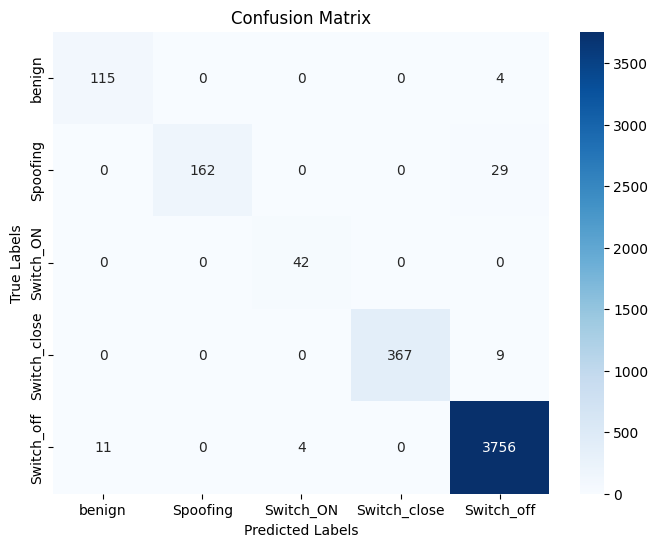

In [110]:
conf_matrix = confusion_matrix(y_test_labels_types, y_pred_labels_types)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['benign', 'Spoofing', 'Switch_ON', 'Switch_close', 'Switch_off'],
            yticklabels=['benign', 'Spoofing', 'Switch_ON', 'Switch_close', 'Switch_off'])
plt.title('Confusion matrix (attack type classification)')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

We can see that our model is very good a detecting the attack type (here on the test dataset) with a slightly more errors on the `Switch of` attack predictions

### Attack types with labels

The same architecture was used but included the binary anomaly label information as an additional feature. This provided slightly better performance due to the additional contextual information.

In [111]:
df_for_mlp_types_labels = pd.concat([attacks, labels, prepare_dfs([p1_, p2_, p3_, p4_, p5_, p6_])], axis=1).copy()

In [112]:
X_types_labels = df_for_mlp_types_labels.drop(['Attack'], axis=1)
y_types_labels = df_for_mlp_types_labels['Attack']

In [ ]:
y_types_encoded_labels = pd.get_dummies(y_types_labels).values

X_train_types_labels, X_test_types_labels, y_train_types_labels, y_test_types_labels = train_test_split(X_types_labels, y_types_encoded_labels, test_size=0.3, random_state=42)

In [113]:
model_types_labels = Sequential([
    Dense(64, activation='relu', input_dim=X_train_types_labels.shape[1]),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(5, activation='softmax')
])

model_types_labels.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_types_labels.fit(X_train_types_labels, y_train_types_labels, epochs=30, batch_size=32, validation_split=0.2)

Epoch 1/30


c:\Users\rokra\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6886 - loss: 30.5298 - val_accuracy: 0.8952 - val_loss: 0.2660
Epoch 2/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8680 - loss: 0.3907 - val_accuracy: 0.9157 - val_loss: 0.1862
Epoch 3/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8959 - loss: 0.2913 - val_accuracy: 0.9452 - val_loss: 0.2776
Epoch 4/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9144 - loss: 0.2702 - val_accuracy: 0.9276 - val_loss: 0.2072
Epoch 5/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9196 - loss: 0.2318 - val_accuracy: 0.9714 - val_loss: 0.1217
Epoch 6/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9367 - loss: 0.1670 - val_accuracy: 0.9195 - val_loss: 0.6198
Epoch 7/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9245 - loss: 0.3459 - val_accuracy: 0.9548 - val_loss: 0.1129
Epoch 8/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9514 - loss: 0.1409 - val_accuracy: 0.9629 - val

In [ ]:
y_pred_types_labels = model_types_labels.predict(X_test_types_labels)
y_pred_labels_types_labels = np.argmax(y_pred_types_labels, axis=1)
y_test_labels_types_labels = np.argmax(y_test_types_labels, axis=1)

print(classification_report(y_test_labels_types, y_pred_labels_types, target_names=['benign', 'Spoofing', 'Switch_ON', 'Switch_close', 'Switch_off']))

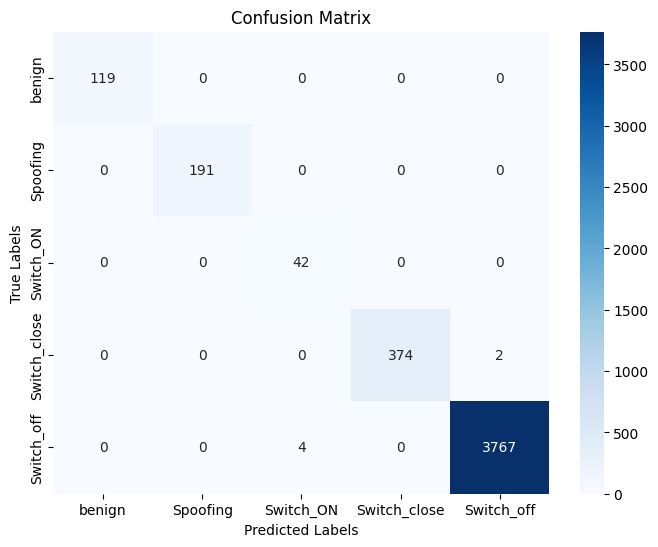

In [114]:
conf_matrix = confusion_matrix(y_test_labels_types_labels, y_pred_labels_types_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['benign', 'Spoofing', 'Switch_ON', 'Switch_close', 'Switch_off'],
            yticklabels=['benign', 'Spoofing', 'Switch_ON', 'Switch_close', 'Switch_off'])
plt.title('Confusion matrix (attack type classification)')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

Now the model is close to the best possible accuracy.

## Without Spoofing extrapolate ?

We decided to implement a new approach to test the model's ability to detect spoofing attacks to see if our model is able to generalize on unseen attacks.

1. Spoofing attacks are excluded from the training data 
2. Testing include all attack types
3. We keep the same classification architecture as before

In [78]:
X = df_for_mlp_types_labels.drop(['Attack', 'Label'], axis=1)
y = df_for_mlp_types_labels['Label'].astype(int)

X_train, X_test, y_train, y_test, train_attacks, test_attacks = train_test_split(
    X, y, df_for_mlp_types_labels['Attack'], test_size=0.3, random_state=42
)

NameError: name 'df_for_mlp_types_labels' is not defined

We remove "Spoofing" from the training set

In [ ]:
train_df = pd.concat([X_train, train_attacks, y_train], axis=1)
train_df = train_df[train_df['Attack'] != 'Spoofing']

X_train_filtered = train_df.drop(['Attack', 'Label'], axis=1)  # features without Attack and Label
y_train_filtered = train_df['Label'].astype(int)

In [130]:
model_filtered = Sequential([
    Dense(64, activation='relu', input_dim=X_train_filtered.shape[1]),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(5, activation='softmax')
])

model_filtered.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model_filtered.fit(X_train_filtered, y_train_filtered, epochs=30, batch_size=32, validation_split=0.2)

Epoch 1/30


c:\Users\rokra\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8508 - loss: 2.2577 - val_accuracy: 0.9302 - val_loss: 0.2780
Epoch 2/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9113 - loss: 0.3873 - val_accuracy: 0.8849 - val_loss: 0.2720
Epoch 3/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9089 - loss: 0.3432 - val_accuracy: 0.9176 - val_loss: 0.4844
Epoch 4/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9082 - loss: 0.3923 - val_accuracy: 0.9298 - val_loss: 0.3009
Epoch 5/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9089 - loss: 0.3347 - val_accuracy: 0.8790 - val_loss: 0.4760
Epoch 6/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9203 - loss: 0.2778 - val_accuracy: 0.8463 - val_loss: 0.6728
Epoch 7/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9399 - loss: 0.2047 - val_accuracy: 0.9805 - val_loss: 0.0866
Epoch 8/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9635 - loss: 0.1070 - val_accuracy: 0.9283 - val_

In [ ]:
y_pred_filtered = model_filtered.predict(X_test)
y_pred_labels_filtered = (y_pred_filtered > 0.5).astype(int)

print(classification_report(y_test, y_pred_labels_filtered))

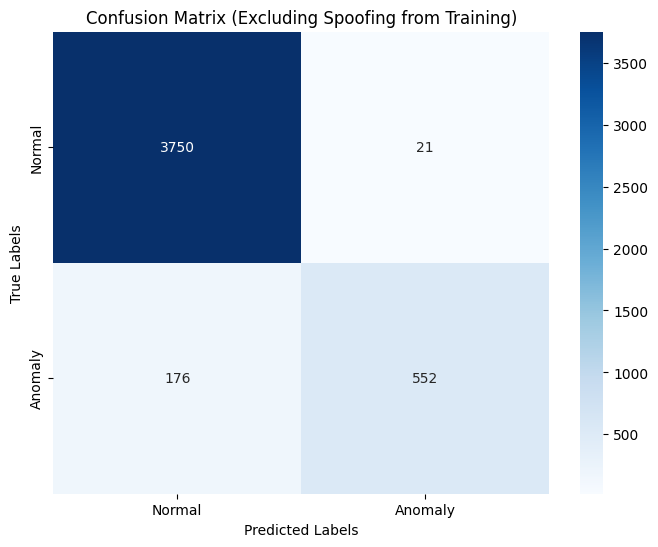

In [131]:
conf_matrix_filtered = confusion_matrix(y_test, y_pred_labels_filtered)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_filtered, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion matrix (excluding spoofing from training)')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [ ]:
test_attacks = test_attacks.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
y_pred_labels_filtered = pd.Series(y_pred_labels_filtered.flatten(), index=y_test.index)

test_results = pd.DataFrame({
    'True Attack': test_attacks,
    'True Label': y_test,
    'Predicted Label': y_pred_labels_filtered
})

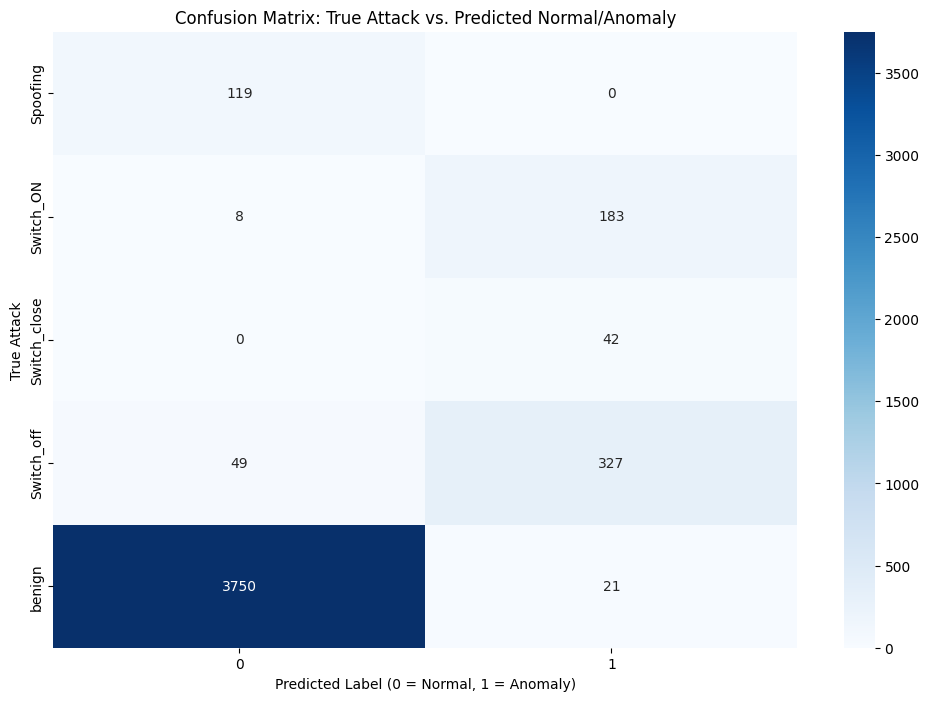

In [132]:
# Generate the confusion matrix: True Attack vs. Predicted Labels
conf_matrix_attack = pd.crosstab(
    test_results['True Attack'],
    test_results['Predicted Label'],
    rownames=['True Attack'],
    colnames=['Predicted Label'],
    dropna=False
)

plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix_attack, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion matrix: true Attack vs. predicted normal/Anomaly')
plt.xlabel('Predicted label (0 = normal, 1 = anomaly)')
plt.ylabel('True attack')
plt.show()

"Spoofing" attacks were frequently misclassified as normal behavior. It shows the incapability from this model to detect novel attack types. That's why supervised deep learning alone might not be sufficient for comprehensive attack detection.

-> Combining supervised and unsupervised approaches might be more effective.